# EDA

In [103]:
from pyspark.sql.functions import col, count, when, lit, sum, min, max, skewness, kurtosis
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.window import Window

def analyze_missing_count(spark, df, column_name):
    missing_count = df.filter(col(column_name).isNull()).count()
    total_count = df.count()        
    print(f"Total Records: {total_count}")
    print(f"Missing: {missing_count} ({(missing_count/total_count)*100:.2f}%)")
    print(f"Non-Missing: {total_count - missing_count} ({((total_count - missing_count)/total_count)*100:.2f}%)")
    return missing_count, total_count
        
def analyze_string_column(spark, df, column_name):
    print(f"\n--- Column: {column_name} ---")
    # [1] Missing Count
    missing_count, total_count = analyze_missing_count(spark, df, column_name)
    
    # [2] Distinct Count
    distinct_count = df.select(column_name).distinct().count()
        
    # [3] Duplicate Count
    # Count distinct groups with duplicates
    num_distinct_with_duplicates = (
        df.groupBy(column_name)
          .count()
          .filter(col("count") > 1)
          .count()
    )
    # Count total duplicate rows (all rows beyond the first occurrence)
    num_duplicate_rows = (
        df.groupBy(column_name)
          .count()
          .filter(col("count") > 1)
          .select(sum(col("count") - 1))
          .collect()[0][0]
    )

    print(f"Distinct Values: {distinct_count} ({(distinct_count/total_count)*100:.2f}%)")
    duplicate_count = num_distinct_with_duplicates + num_duplicate_rows if num_duplicate_rows else num_distinct_with_duplicates
    print(f"Duplicates: {duplicate_count} ({(duplicate_count/total_count)*100:.2f}%)")
    print(
        f"Total duplicate rows beyond first occurrence: "
        f"{num_duplicate_rows or 0}"
        + (f" ({(num_duplicate_rows/total_count)*100:.2f}%)" if num_duplicate_rows else "")
    )
    print(f"Distinct Duplicates: {num_distinct_with_duplicates} ({(num_distinct_with_duplicates/total_count)*100:.2f}%)")

def analyze_numeric_column(spark, df, column_name):
    print(f"\n--- Column: {column_name} ---")
    # [1] Missing Count
    missing_count, total_count = analyze_missing_count(spark, df, column_name)
    
    # [2] Check for Non-Numeric Values
    df_casted = df.withColumn(f"_{column_name}_casted", col(column_name).cast("float"))
    non_numeric_df = df_casted.filter(col(f"_{column_name}_casted").isNull() & col(column_name).isNotNull())
    non_numeric_count = non_numeric_df.count()

    print(f"Non-numeric Values: {non_numeric_count} ({(non_numeric_count/total_count)*100:.2f}%)")
    if non_numeric_count > 0:
        non_numeric_df.select(column_name).show(5, truncate=False)
    
    # [3] Check for Negative Values
    negative_count = df_casted.filter(col(f"_{column_name}_casted") < 0).count()
    print(f"Negative Values: {negative_count} ({(negative_count/total_count)*100:.2f}%)")
    if negative_count > 0:
        df_casted.filter(col(f"_{column_name}_casted") < 0).select(column_name).show(5)

    # [4] Calculate Min, Max, Skewness, and Kurtosis in a single pass
    stats = df_casted.select(
        min(col(f"_{column_name}_casted")).alias("min"),
        max(col(f"_{column_name}_casted")).alias("max"),
        skewness(col(f"_{column_name}_casted")).alias("skewness"),
        kurtosis(col(f"_{column_name}_casted")).alias("kurtosis")
    ).first()


    print("\n--- Statistics ---")
    print(f"Min: {stats['min']:.2f}")
    print(f"Max: {stats['max']:.2f}")
    print(f"Skewness: {stats['skewness']:.2f}" if stats['skewness'] is not None else "Skewness: NA")    
    print(f"Kurtosis: {stats['kurtosis']:.2f}" if stats['kurtosis'] is not None else "Kurtosis: NA")    

    # [4] Calculate Quantiles and IQR for Outlier Detection
    quantiles = df_casted.approxQuantile(f"_{column_name}_casted", [0.05, 0.25, 0.75, 0.95], 0.01)
    p5 = quantiles[0]
    q1 = quantiles[1]
    q3 = quantiles[2]
    p95 = quantiles[3]
        
    # Handle case where quantiles might be null if column is all nulls
    if q1 is not None and q3 is not None:
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        print(f"5th Percentile: {p5:.2f}")
        print(f"25th Percentile (Q1): {q1:.2f}")
        print(f"75th Percentile (Q3): {q3:.2f}")
        print(f"95th Percentile: {p95:.2f}")
        print(f"Interquartile Range (IQR): {iqr:.2f}")
        print(f"IQR Outlier Bounds: {lower_bound:.2f} to {upper_bound:.2f}")
            
        # [3] Count the number of outliers
        outlier_count = df_casted.filter(
            (col(column_name) < lower_bound) | (col(column_name) > upper_bound)
        ).count()
        
        total_count = df_casted.count()
        outlier_percentage = (outlier_count / total_count) * 100 if total_count > 0 else 0

        print(f"Outliers: {outlier_count} ({outlier_percentage:.2f}%)")
    else:
        print("Could not calculate quantiles. The column may be entirely null or contain insufficient data.")

    # plot the diagram
    plot_distribution(df_casted, column_name)
    

def plot_distribution(df, column_name):

    pandas_df = df.select(f"_{column_name}_casted").toPandas().dropna()
    p95 = pandas_df[f"_{column_name}_casted"].quantile(0.95)

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(1, 3, figsize=(12, 3))

    # Full distribution
    sns.histplot(pandas_df[f"_{column_name}_casted"], bins=20, kde=True, ax=axes[0], color="blue")
    axes[0].set_title(f"Distribution", fontsize=10)
    axes[0].set_xlabel(column_name)
    axes[0].set_ylabel("Count")

    # Zoomed-in up to 95th percentile
    sns.histplot(pandas_df[f"_{column_name}_casted"], bins="auto", kde=True, ax=axes[1], color="green")
    axes[1].set_xlim(0, p95)
    axes[1].set_title(f"Distribution (P95)", fontsize=10)
    axes[1].set_xlabel(column_name)

    # Zoomed-in negative values zone
    sns.histplot(pandas_df[f"_{column_name}_casted"], bins="auto", kde=True, ax=axes[2], color="red")
    axes[2].set_xlim(-600, p95)
    axes[2].set_title(f"Distribution (negative)", fontsize=10)
    axes[2].set_xlabel(column_name)
    
    plt.tight_layout()
    plt.show()
    
def show_duplicates(df, column_name):
    # [1] Group by the column of interest and count the occurrences of each value.
    df_counts = df.groupBy(column_name).count()

    # [2] Filter to find the values that appear more than once.
    duplicates_df = df_counts.filter(col("count") > 1)

    # [3] Display the results.
    # This shows only the values that are duplicated and how many times they appear.
    if duplicates_df.count() > 0:
        duplicates_df.orderBy(col(column_name).asc()).show(truncate=False)
    else:
        print("No duplicate values found in this column.")

# Customer Attributes

## Customer CSV Data Analysis

25/10/04 12:58:38 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/10/04 12:58:38 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


--- EDA for: data/features_attributes.csv ---

--- Column: Customer_ID ---
Total Records: 12500
Missing: 0 (0.00%)
Non-Missing: 12500 (100.00%)
Distinct Values: 12500 (100.00%)
Duplicates: 0 (0.00%)
Total duplicate rows beyond first occurrence: 0
Distinct Duplicates: 0 (0.00%)
No duplicate values found in this column.

--- Column: Name ---
Total Records: 12500
Missing: 0 (0.00%)
Non-Missing: 12500 (100.00%)
Distinct Values: 10139 (81.11%)
Duplicates: 4184 (33.47%)
Total duplicate rows beyond first occurrence: 2361 (18.89%)
Distinct Duplicates: 1823 (14.58%)
+--------------------+-----+
|Name                |count|
+--------------------+-----+
|"""John ODonnell""a"|2    |
|"""John ODonnell""e"|2    |
|"""John ODonnell""n"|2    |
|"""John ODonnell""z"|2    |
|"""Johnc"           |3    |
|"""Johnd"           |2    |
|"""Johne"           |2    |
|"""Johnk"           |2    |
|"""Johnn"           |3    |
|"""Johnr"           |2    |
|"""Johnw"           |2    |
|"ODonnell""e"       |2    |
|

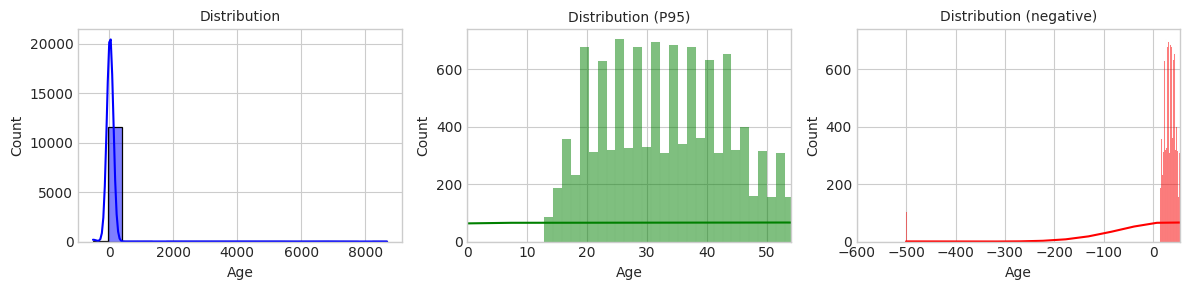

In [104]:
FILE_PATH = "data/features_attributes.csv"
spark = SparkSession.builder.appName("EDA").getOrCreate()
spark.sparkContext.setLogLevel("WARN")

try:
    header = spark.read.csv(FILE_PATH, header=True).columns
    df = spark.read.csv(FILE_PATH, header=True)
    print(f"--- EDA for: {FILE_PATH} ---")
    # --- String Column ---
    fields = ["Customer_ID","Name","SSN","Occupation"]
    for field in fields:
        analyze_string_column(spark, df, field)
        show_duplicates(df, field)

    # --- Numeric Column ---
    fields = ["Age"]
    for field in fields:
        analyze_numeric_column(spark, df, field)

except Exception as e:
    print(f"ERROR: Could not process the file. Details: {e}")

spark.stop()


## Customer Silve Data Analysis (Silver data)

25/10/04 12:58:53 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/10/04 12:58:53 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


--- EDA for: datamart/silver/fe_attributes/silver_features_attributes*.parquet ---

--- Column: Customer_ID ---
Total Records: 11512
Missing: 0 (0.00%)
Non-Missing: 11512 (100.00%)
Distinct Values: 11512 (100.00%)
Duplicates: 0 (0.00%)
Total duplicate rows beyond first occurrence: 0
Distinct Duplicates: 0 (0.00%)
No duplicate values found in this column.

--- Column: Name ---
Total Records: 11512
Missing: 0 (0.00%)
Non-Missing: 11512 (100.00%)
Distinct Values: 9486 (82.40%)
Duplicates: 3624 (31.48%)
Total duplicate rows beyond first occurrence: 2026 (17.60%)
Distinct Duplicates: 1598 (13.88%)
+----------------------------+-----+
|Name                        |count|
+----------------------------+-----+
|"""""""John ODonnell""""a"""|2    |
|"""""""John ODonnell""""e"""|2    |
|"""""""John ODonnell""""n"""|2    |
|"""""""John ODonnell""""z"""|2    |
|"""""""Johnc"""             |2    |
|"""""""Johnd"""             |2    |
|"""""""Johnk"""             |2    |
|"""""""Johnn"""             |

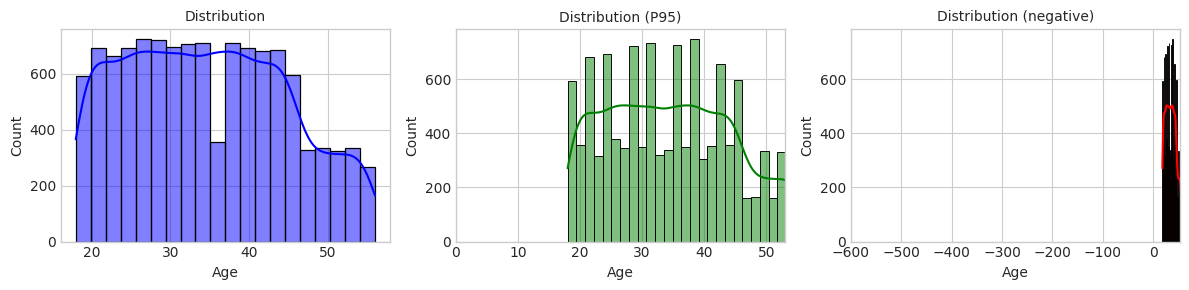

In [105]:
FILE_PATH = "datamart/silver/fe_attributes/silver_features_attributes*.parquet"
spark = SparkSession.builder.appName("EDA").getOrCreate()
spark.sparkContext.setLogLevel("WARN")

try:
    df = spark.read.parquet(FILE_PATH)
    
    print(f"--- EDA for: {FILE_PATH} ---")
    # --- String Column ---
    fields = ["Customer_ID","Name","SSN","Occupation"]
    for field in fields:
        analyze_string_column(spark, df, field)
        show_duplicates(df, field)

    # --- Numeric Column ---
    fields = ["Age"]
    for field in fields:
        analyze_numeric_column(spark, df, field)
    
except Exception as e:
    print(f"ERROR: Could not process the file. Details: {e}")

spark.stop()

## Age_Group binning

25/10/04 12:59:30 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/10/04 12:59:30 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


+---------+-----+
|Age_Group|count|
+---------+-----+
|        2|   96|
|        3|  136|
|        4|  133|
|        5|   72|
|        6|   18|
+---------+-----+


--- binned_df DataFrame[Age_Group: int, Customer_ID: string, Name: string, Age: int, SSN: string, Occupation: string, snapshot_date: date, Age_Group_Ceiling: string]


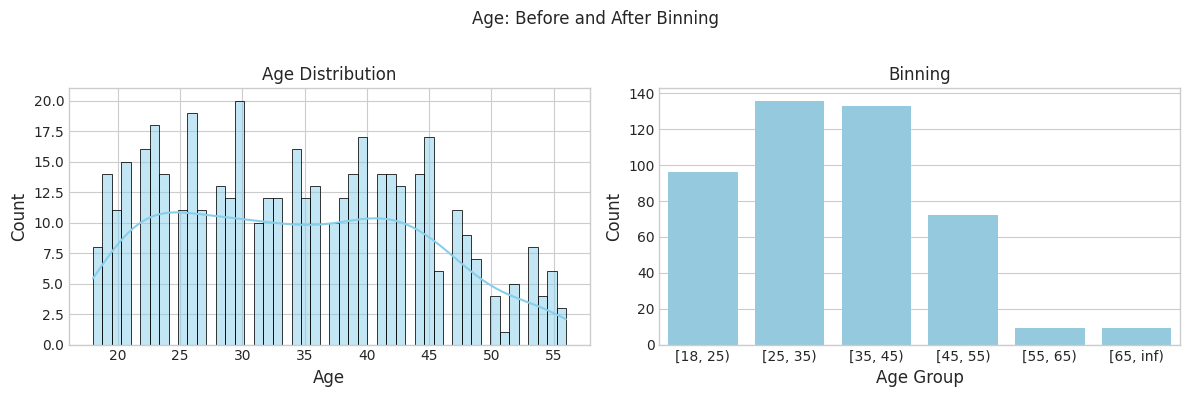

In [106]:
def create_bins(spark, df):
    AGE_GROUP = {
        1: 18.0, # [0, 18)
        2: 25.0, # [18, 25)
        3: 35.0, # [25, 35)
        4: 45.0, # [35, 45)
        5: 55.0, # [45, 55)
        6: 65.0, # [55, 65)
        7: float("inf") # [65, inf)
    }
    df_binned = df.withColumn("Age_Group",
        when(col("Age") < AGE_GROUP[1], lit(1))
        .when((col("Age") >= AGE_GROUP[1]) & (col("Age") < AGE_GROUP[2]), lit(2))
        .when((col("Age") >= AGE_GROUP[2]) & (col("Age") < AGE_GROUP[3]), lit(3))
        .when((col("Age") >= AGE_GROUP[3]) & (col("Age") < AGE_GROUP[4]), lit(4))
        .when((col("Age") >= AGE_GROUP[4]) & (col("Age") < AGE_GROUP[5]), lit(5))
        .when((col("Age") >= AGE_GROUP[5]) & (col("Age") < AGE_GROUP[6]), lit(6))
        .otherwise(lit(7)) # Anything above 
    )
    
    bin_definitions_data = [
        (1, "[0,18)"),
        (2, "[18, 25)"),
        (3, "[25, 35)"),
        (4, "[35, 45)"),
        (5, "[45, 55)"),
        (6, "[55, 65)"),
        (6, "[65, inf)"),
    ]
    
    bins_df = spark.createDataFrame(bin_definitions_data, ["Age_Group", "Age_Group_Ceiling"])
    
    return df_binned.join(bins_df, on="Age_Group", how="left")


def plot_income_distributions(raw_df, binned_df):
    print("\n--- binned_df", binned_df)
    
    try:
        # Prepare data for the "Before" plot (raw distribution)
        raw_pandas_df = raw_df.select("Age").toPandas().dropna()

        # Prepare data for the "After" plot (binned distribution)
        counts_df = binned_df.groupBy("Age_Group_Ceiling", "Age_Group").count().orderBy("Age_Group")
        binned_pandas_df = counts_df.toPandas()

        plt.style.use('seaborn-v0_8-whitegrid')
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        fig.suptitle('Age: Before and After Binning', fontsize=12)
        # --- Left Plot: Raw Distribution ---
        sns.histplot(data=raw_pandas_df, x="Age", bins=50, kde=True, ax=axes[0], color='skyblue')
        axes[0].set_title('Age Distribution', fontsize=12)
        axes[0].set_xlabel('Age', fontsize=12)
        axes[0].set_ylabel('Count', fontsize=12)
        # --- Right Plot: Binned Distribution ---
        sns.barplot(x="Age_Group_Ceiling", y="count", data=binned_pandas_df, ax=axes[1], color='skyblue')
        axes[1].set_title('Binning', fontsize=12)
        axes[1].set_xlabel('Age Group', fontsize=12)
        axes[1].set_ylabel('Count', fontsize=12)

        plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle        
        plt.show()
        plt.close()

    except Exception as e:
        print(f"Could not generate combined plot. Error: {e}")

FILE_PATH = "datamart/silver/fe_attributes/silver_features_attributes_2024_01_01.parquet"
spark = SparkSession.builder.appName("EDA").getOrCreate()
spark.sparkContext.setLogLevel("WARN")

try:
    df = spark.read.parquet(FILE_PATH)

    df_binned = create_bins(spark, df)
    df_binned.groupBy("Age_Group").count().orderBy("Age_Group").show() 
    plot_income_distributions(df, df_binned)

except Exception as e:
    print(f"ERROR: Could not process the file. Details: {e}")

spark.stop()

## Customer Quarantine Data Analysis

25/10/04 12:59:43 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/10/04 12:59:43 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


--- EDA for: datamart/silver/quarantine/quarantine_silver_features_attributes*.parquet ---

--- Column: Customer_ID ---
Total Records: 988
Missing: 0 (0.00%)
Non-Missing: 988 (100.00%)
Distinct Values: 988 (100.00%)
Duplicates: 0 (0.00%)
Total duplicate rows beyond first occurrence: 0
Distinct Duplicates: 0 (0.00%)
No duplicate values found in this column.

--- Column: Name ---
Total Records: 988
Missing: 0 (0.00%)
Non-Missing: 988 (100.00%)
Distinct Values: 976 (98.79%)
Duplicates: 24 (2.43%)
Total duplicate rows beyond first occurrence: 12 (1.21%)
Distinct Duplicates: 12 (1.21%)
+----------------------+-----+
|Name                  |count|
+----------------------+-----+
|Alan Wheatleyx        |2    |
|Alexei Oreskovics     |2    |
|Caroline Valetkevitcho|2    |
|Dougm                 |2    |
|Jonathano             |2    |
|McCrankr              |2    |
|Michelle Martinh      |2    |
|Nickq                 |2    |
|Schnurrr              |2    |
|Scott Maloneq         |2    |
|Shalal-E

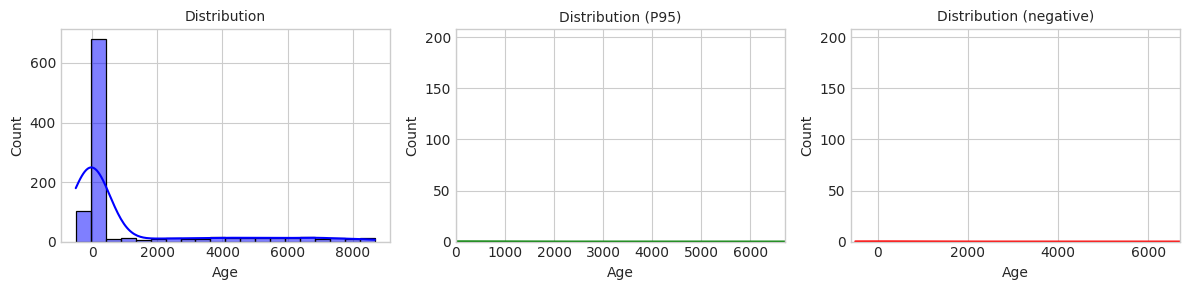

In [107]:
FILE_PATH = "datamart/silver/quarantine/quarantine_silver_features_attributes*.parquet"
spark = SparkSession.builder.appName("EDA").getOrCreate()
spark.sparkContext.setLogLevel("WARN")

try:
    df = spark.read.parquet(FILE_PATH)
    
    print(f"--- EDA for: {FILE_PATH} ---")
    # --- String Column ---
    fields = ["Customer_ID","Name","SSN","Occupation"]
    for field in fields:
        analyze_string_column(spark, df, field)
        show_duplicates(df, field)

    # --- Numeric Column ---
    fields = ["Age"]
    for field in fields:
        analyze_numeric_column(spark, df, field)

except Exception as e:
    print(f"ERROR: Could not process the file. Details: {e}")

spark.stop()

# Financials

## Financials CSV Data Analysis

25/10/04 13:00:02 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/10/04 13:00:02 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


--- EDA for: data/features_financials.csv ---

--- Column: Customer_ID ---
Total Records: 12500
Missing: 0 (0.00%)
Non-Missing: 12500 (100.00%)
Distinct Values: 12500 (100.00%)
Duplicates: 0 (0.00%)
Total duplicate rows beyond first occurrence: 0
Distinct Duplicates: 0 (0.00%)
No duplicate values found in this column.

--- Column: Type_of_Loan ---
Total Records: 12500
Missing: 1426 (11.41%)
Non-Missing: 11074 (88.59%)
Distinct Values: 6261 (50.09%)
Duplicates: 7120 (56.96%)
Total duplicate rows beyond first occurrence: 6239 (49.91%)
Distinct Duplicates: 881 (7.05%)
+------------------------------------------------------------------+-----+
|Type_of_Loan                                                      |count|
+------------------------------------------------------------------+-----+
|NULL                                                              |1426 |
|Auto Loan                                                         |144  |
|Auto Loan, Auto Loan, Auto Loan, and Home Equity Loa

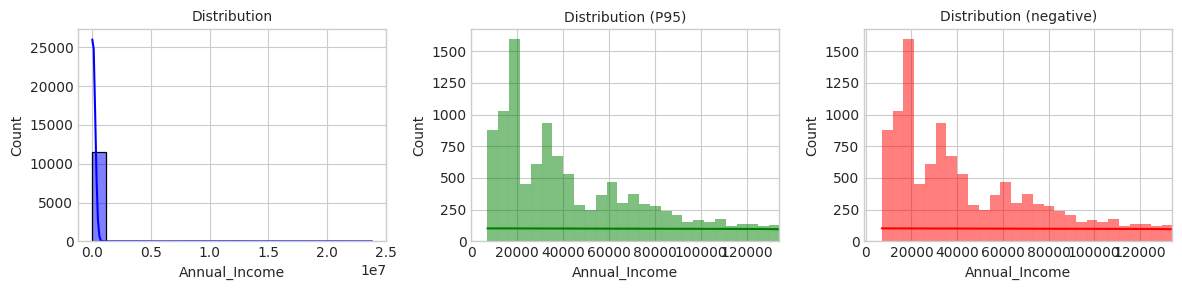


--- Column: Monthly_Inhand_Salary ---
Total Records: 12500
Missing: 0 (0.00%)
Non-Missing: 12500 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 303.65
Max: 15204.63
Skewness: 1.13
Kurtosis: 0.62
5th Percentile: 884.78
25th Percentile (Q1): 1600.83
75th Percentile (Q3): 5881.75
95th Percentile: 10426.82
Interquartile Range (IQR): 4280.92
IQR Outlier Bounds: -4820.54 to 12303.13
Outliers: 275 (2.20%)


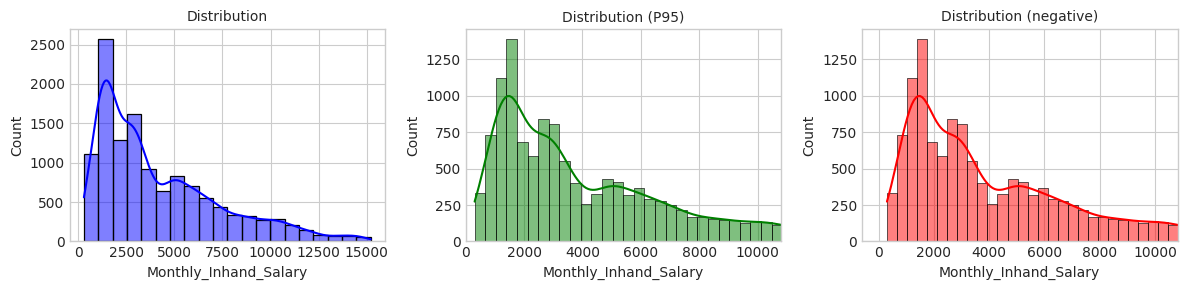


--- Column: Num_Bank_Accounts ---
Total Records: 12500
Missing: 0 (0.00%)
Non-Missing: 12500 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 4 (0.03%)
+-----------------+
|Num_Bank_Accounts|
+-----------------+
|               -1|
|               -1|
|               -1|
|               -1|
+-----------------+


--- Statistics ---
Min: -1.00
Max: 1756.00
Skewness: 11.11
Kurtosis: 131.09
5th Percentile: 1.00
25th Percentile (Q1): 3.00
75th Percentile (Q3): 7.00
95th Percentile: 10.00
Interquartile Range (IQR): 4.00
IQR Outlier Bounds: -3.00 to 13.00
Outliers: 167 (1.34%)


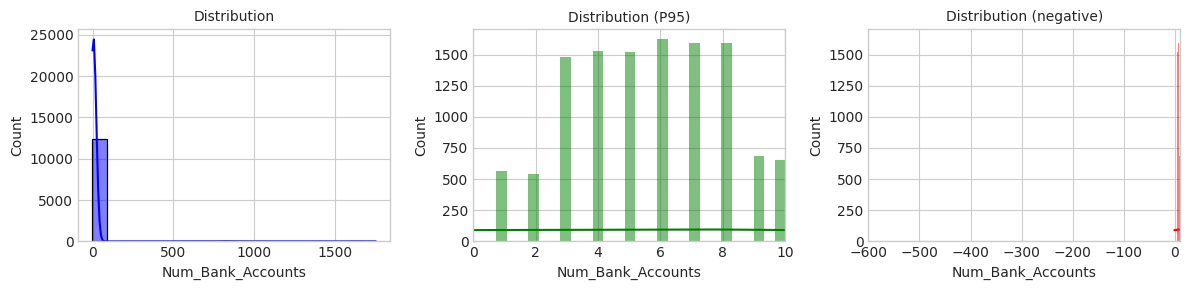


--- Column: Num_Credit_Card ---
Total Records: 12500
Missing: 0 (0.00%)
Non-Missing: 12500 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 0.00
Max: 1499.00
Skewness: 8.31
Kurtosis: 71.84
5th Percentile: 3.00
25th Percentile (Q1): 4.00
75th Percentile (Q3): 7.00
95th Percentile: 10.00
Interquartile Range (IQR): 3.00
IQR Outlier Bounds: -0.50 to 11.50
Outliers: 296 (2.37%)


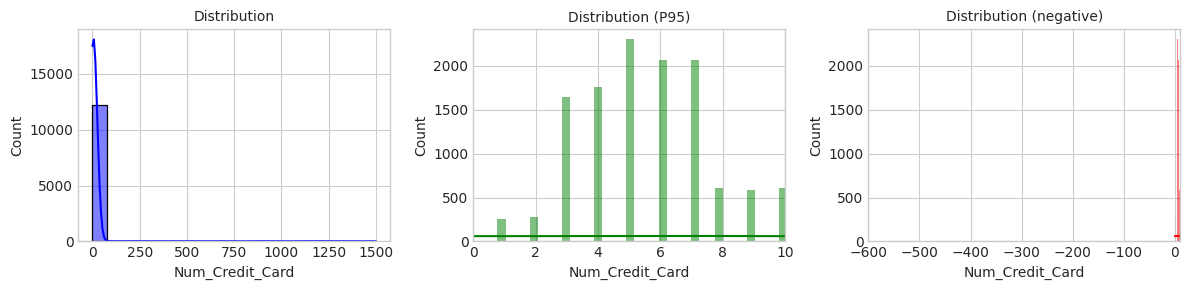


--- Column: Interest_Rate ---
Total Records: 12500
Missing: 0 (0.00%)
Non-Missing: 12500 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 1.00
Max: 5789.00
Skewness: 9.01
Kurtosis: 85.25
5th Percentile: 3.00
25th Percentile (Q1): 7.00
75th Percentile (Q3): 20.00
95th Percentile: 32.00
Interquartile Range (IQR): 13.00
IQR Outlier Bounds: -12.50 to 39.50
Outliers: 270 (2.16%)


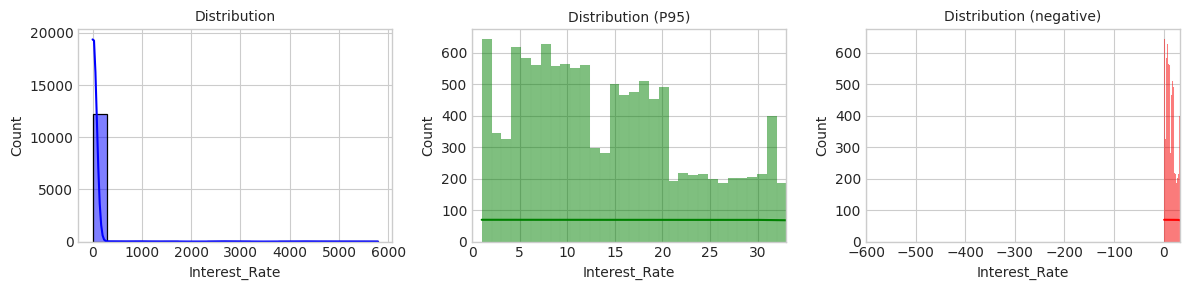


--- Column: Num_of_Loan ---
Total Records: 12500
Missing: 0 (0.00%)
Non-Missing: 12500 (100.00%)
Non-numeric Values: 623 (4.98%)
+-----------+
|Num_of_Loan|
+-----------+
|1_         |
|6_         |
|2_         |
|2_         |
|4_         |
+-----------+
only showing top 5 rows

Negative Values: 500 (4.00%)
+-----------+
|Num_of_Loan|
+-----------+
|       -100|
|       -100|
|       -100|
|       -100|
|       -100|
+-----------+
only showing top 5 rows


--- Statistics ---
Min: -100.00
Max: 1495.00
Skewness: 15.76
Kurtosis: 298.12
5th Percentile: 0.00
25th Percentile (Q1): 1.00
75th Percentile (Q3): 5.00
95th Percentile: 8.00
Interquartile Range (IQR): 4.00
IQR Outlier Bounds: -5.00 to 11.00
Outliers: 563 (4.50%)


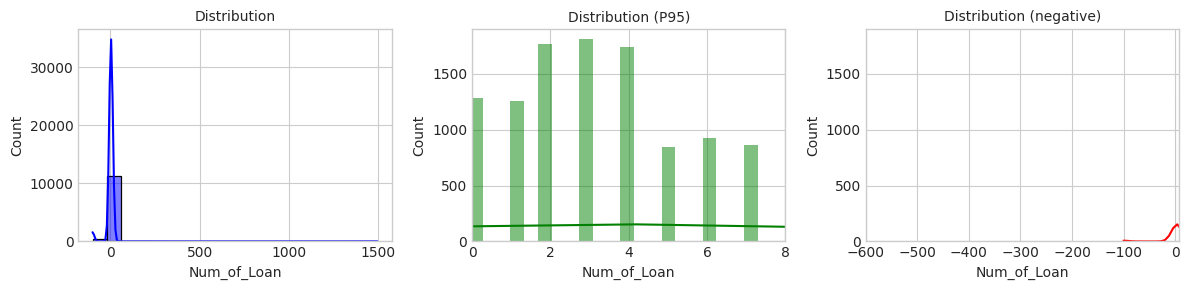


--- Column: Delay_from_due_date ---
Total Records: 12500
Missing: 0 (0.00%)
Non-Missing: 12500 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 88 (0.70%)
+-------------------+
|Delay_from_due_date|
+-------------------+
|                 -1|
|                 -1|
|                 -1|
|                 -4|
|                 -1|
+-------------------+
only showing top 5 rows


--- Statistics ---
Min: -5.00
Max: 67.00
Skewness: 0.97
Kurtosis: 0.35
5th Percentile: 3.00
25th Percentile (Q1): 10.00
75th Percentile (Q3): 28.00
95th Percentile: 52.00
Interquartile Range (IQR): 18.00
IQR Outlier Bounds: -17.00 to 55.00
Outliers: 504 (4.03%)


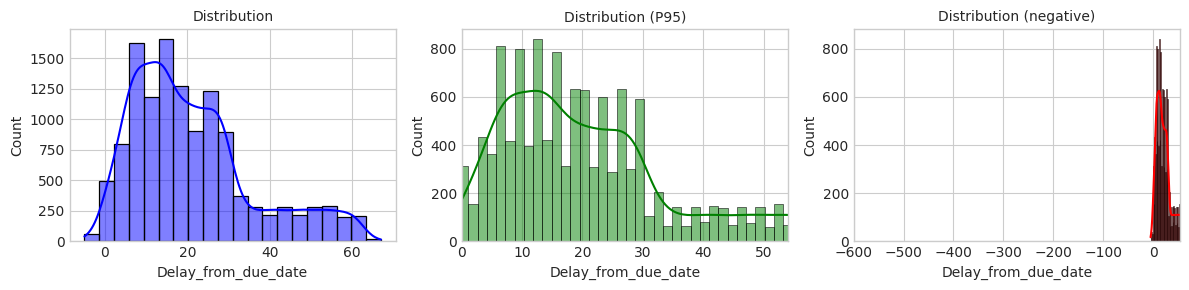


--- Column: Num_of_Delayed_Payment ---
Total Records: 12500
Missing: 0 (0.00%)
Non-Missing: 12500 (100.00%)
Non-numeric Values: 374 (2.99%)
+----------------------+
|Num_of_Delayed_Payment|
+----------------------+
|18_                   |
|20_                   |
|0_                    |
|9_                    |
|19_                   |
+----------------------+
only showing top 5 rows

Negative Values: 80 (0.64%)
+----------------------+
|Num_of_Delayed_Payment|
+----------------------+
|                    -2|
|                    -1|
|                    -1|
|                    -1|
|                    -2|
+----------------------+
only showing top 5 rows


--- Statistics ---
Min: -3.00
Max: 4293.00
Skewness: 13.26
Kurtosis: 185.22
5th Percentile: 2.00
25th Percentile (Q1): 9.00
75th Percentile (Q3): 18.00
95th Percentile: 23.00
Interquartile Range (IQR): 9.00
IQR Outlier Bounds: -4.50 to 31.50
Outliers: 101 (0.81%)


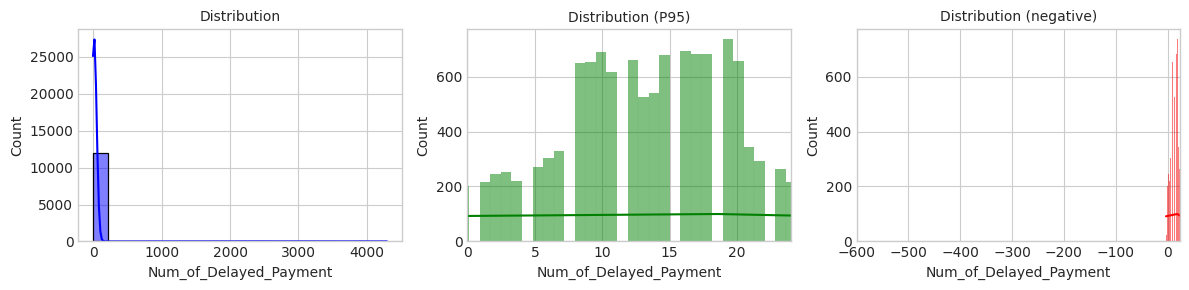


--- Column: Changed_Credit_Limit ---
Total Records: 12500
Missing: 0 (0.00%)
Non-Missing: 12500 (100.00%)
Non-numeric Values: 254 (2.03%)
+--------------------+
|Changed_Credit_Limit|
+--------------------+
|_                   |
|_                   |
|_                   |
|_                   |
|_                   |
+--------------------+
only showing top 5 rows

Negative Values: 204 (1.63%)
+--------------------+
|Changed_Credit_Limit|
+--------------------+
|               -1.64|
|               -2.16|
|               -3.97|
|                -3.5|
|               -4.75|
+--------------------+
only showing top 5 rows


--- Statistics ---
Min: -6.49
Max: 36.97
Skewness: 0.63
Kurtosis: 0.09
5th Percentile: 1.09
25th Percentile (Q1): 5.32
75th Percentile (Q3): 14.55
95th Percentile: 22.49
Interquartile Range (IQR): 9.23
IQR Outlier Bounds: -8.52 to 28.40
Outliers: 159 (1.27%)


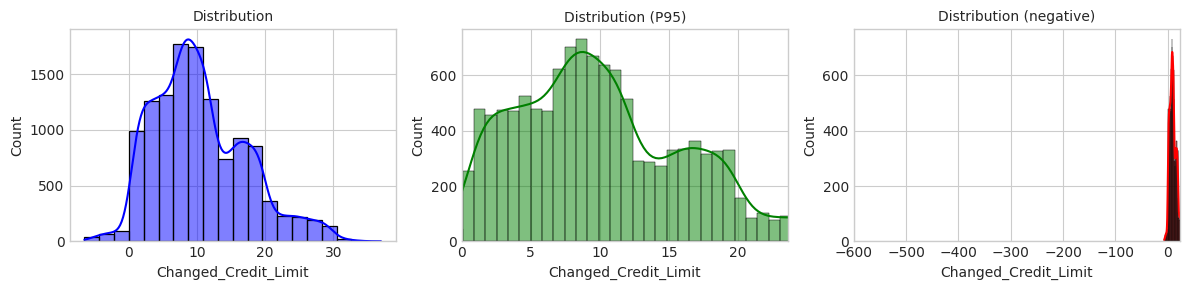


--- Column: Num_Credit_Inquiries ---
Total Records: 12500
Missing: 0 (0.00%)
Non-Missing: 12500 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 0.00
Max: 2554.00
Skewness: 10.18
Kurtosis: 108.70
5th Percentile: 1.00
25th Percentile (Q1): 3.00
75th Percentile (Q3): 10.00
95th Percentile: 14.00
Interquartile Range (IQR): 7.00
IQR Outlier Bounds: -7.50 to 20.50
Outliers: 195 (1.56%)


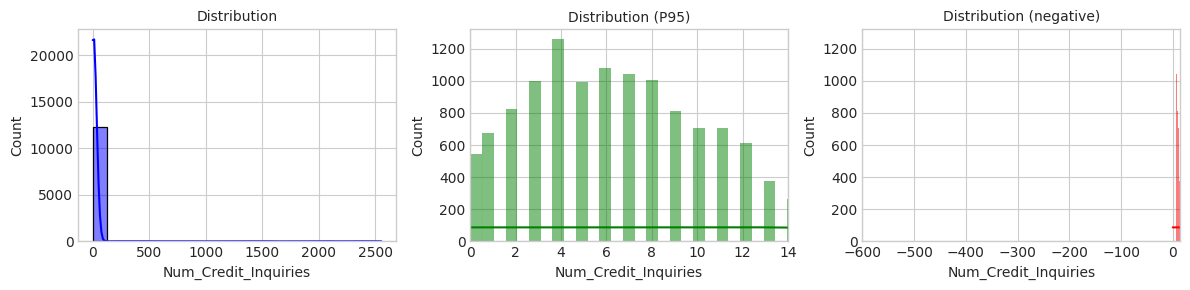


--- Column: Outstanding_Debt ---
Total Records: 12500
Missing: 0 (0.00%)
Non-Missing: 12500 (100.00%)
Non-numeric Values: 139 (1.11%)
+----------------+
|Outstanding_Debt|
+----------------+
|2699.17_        |
|642.42_         |
|755.17_         |
|865.3_          |
|149.92_         |
+----------------+
only showing top 5 rows

Negative Values: 0 (0.00%)

--- Statistics ---
Min: 0.23
Max: 4998.07
Skewness: 1.21
Kurtosis: 0.90
5th Percentile: 100.85
25th Percentile (Q1): 557.38
75th Percentile (Q3): 1891.10
95th Percentile: 3894.03
Interquartile Range (IQR): 1333.72
IQR Outlier Bounds: -1443.20 to 3891.68
Outliers: 732 (5.86%)


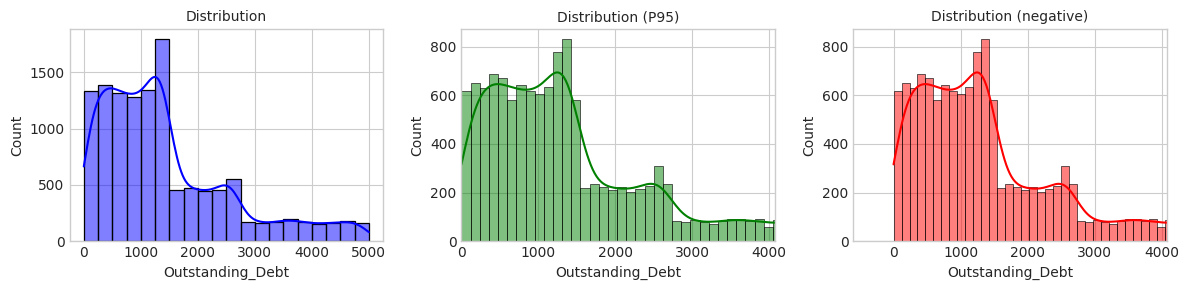


--- Column: Credit_Utilization_Ratio ---
Total Records: 12500
Missing: 0 (0.00%)
Non-Missing: 12500 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 20.10
Max: 48.20
Skewness: 0.00
Kurtosis: -0.97
5th Percentile: 24.41
25th Percentile (Q1): 27.91
75th Percentile (Q3): 36.53
95th Percentile: 39.98
Interquartile Range (IQR): 8.62
IQR Outlier Bounds: 14.98 to 49.45
Outliers: 0 (0.00%)


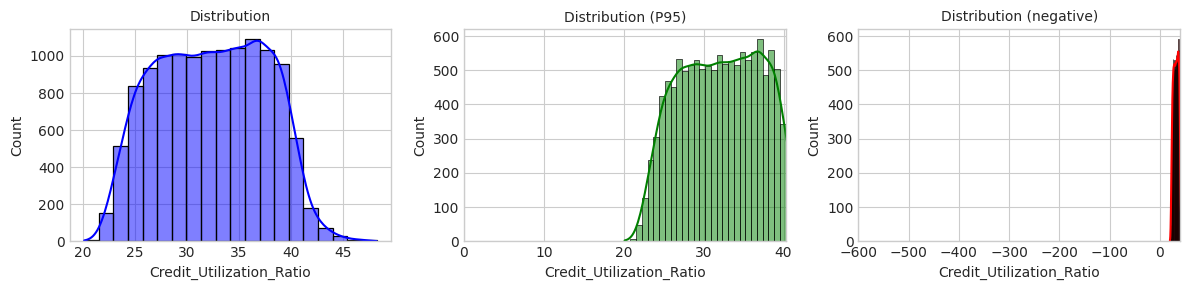


--- Column: Total_EMI_per_month ---
Total Records: 12500
Missing: 0 (0.00%)
Non-Missing: 12500 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 0.00
Max: 81971.00
Skewness: 6.93
Kurtosis: 49.69
5th Percentile: 0.00
25th Percentile (Q1): 30.36
75th Percentile (Q3): 166.12
95th Percentile: 455.60
Interquartile Range (IQR): 135.76
IQR Outlier Bounds: -173.28 to 369.76
Outliers: 965 (7.72%)


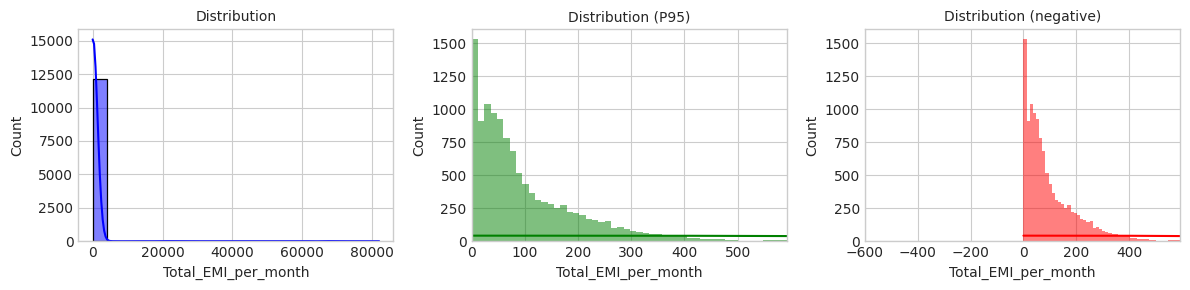


--- Column: Amount_invested_monthly ---
Total Records: 12500
Missing: 0 (0.00%)
Non-Missing: 12500 (100.00%)
Non-numeric Values: 558 (4.46%)
+-----------------------+
|Amount_invested_monthly|
+-----------------------+
|__10000__              |
|__10000__              |
|__10000__              |
|__10000__              |
|__10000__              |
+-----------------------+
only showing top 5 rows

Negative Values: 0 (0.00%)

--- Statistics ---
Min: 0.00
Max: 1977.33
Skewness: 2.58
Kurtosis: 8.81
5th Percentile: 30.76
25th Percentile (Q1): 71.35
75th Percentile (Q3): 229.22
95th Percentile: 569.63
Interquartile Range (IQR): 157.87
IQR Outlier Bounds: -165.45 to 466.02
Outliers: 1071 (8.57%)


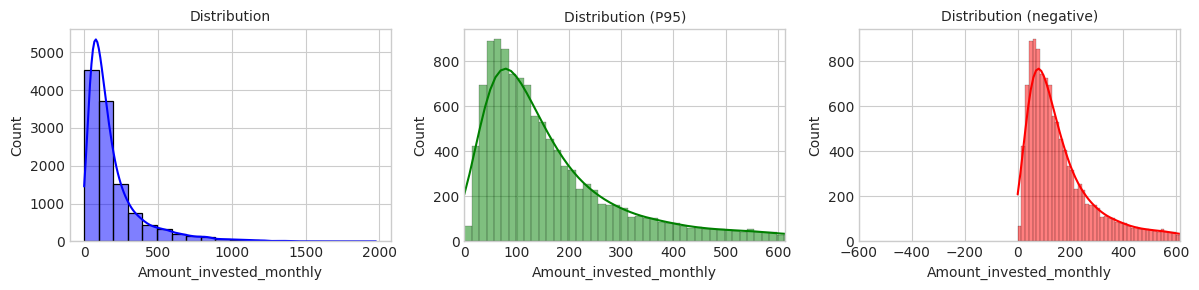


--- Column: Monthly_Balance ---
Total Records: 12500
Missing: 0 (0.00%)
Non-Missing: 12500 (100.00%)
Non-numeric Values: 1 (0.01%)
+--------------------------------+
|Monthly_Balance                 |
+--------------------------------+
|__-333333333333333333333333333__|
+--------------------------------+

Negative Values: 0 (0.00%)

--- Statistics ---
Min: 0.38
Max: 1463.79
Skewness: 1.55
Kurtosis: 2.73
5th Percentile: 178.30
25th Percentile (Q1): 271.20
75th Percentile (Q3): 466.91
95th Percentile: 829.61
Interquartile Range (IQR): 195.71
IQR Outlier Bounds: -22.36 to 760.47
Outliers: 1011 (8.09%)


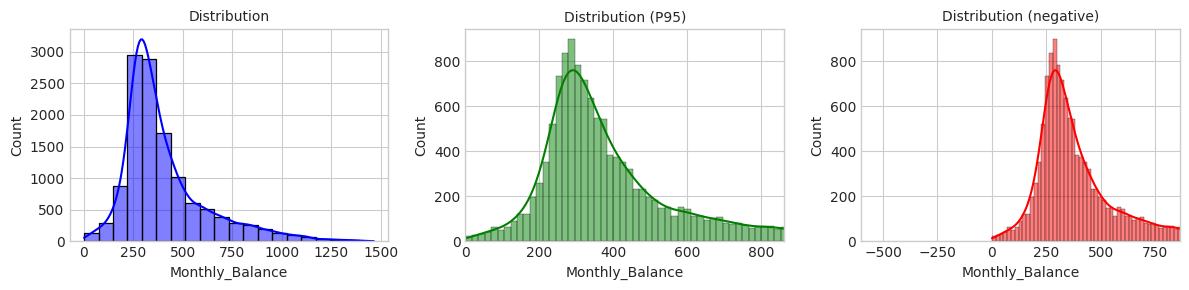

In [108]:
FILE_PATH = "data/features_financials.csv"
spark = SparkSession.builder.appName("EDA").getOrCreate()
spark.sparkContext.setLogLevel("WARN")

try:
    header = spark.read.csv(FILE_PATH, header=True).columns
    df = spark.read.csv(FILE_PATH, header=True)
    print(f"--- EDA for: {FILE_PATH} ---")
    # --- String Column ---
    fields = ["Customer_ID","Type_of_Loan","Credit_Mix","Credit_History_Age","Payment_of_Min_Amount","Payment_Behaviour"]
    for field in fields:
        analyze_string_column(spark, df, field)
        show_duplicates(df, field)

    # --- Numeric Column ---
    fields = ["Annual_Income","Monthly_Inhand_Salary","Num_Bank_Accounts","Num_Credit_Card","Interest_Rate","Num_of_Loan","Delay_from_due_date","Num_of_Delayed_Payment",
              "Changed_Credit_Limit","Num_Credit_Inquiries","Outstanding_Debt","Credit_Utilization_Ratio","Total_EMI_per_month","Amount_invested_monthly","Monthly_Balance"]
    for field in fields:
        analyze_numeric_column(spark, df, field)


except Exception as e:
    print(f"ERROR: Could not process the file. Details: {e}")

spark.stop()

## Financials Silver Data Analysis

25/10/04 13:00:58 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/10/04 13:00:58 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


--- EDA for: datamart/silver/fe_financials/silver_features_financials*.parquet ---

--- Column: Customer_ID ---
Total Records: 12128
Missing: 0 (0.00%)
Non-Missing: 12128 (100.00%)
Distinct Values: 12128 (100.00%)
Duplicates: 0 (0.00%)
Total duplicate rows beyond first occurrence: 0
Distinct Duplicates: 0 (0.00%)
No duplicate values found in this column.

--- Column: Type_of_Loan ---
Total Records: 12128
Missing: 1359 (11.21%)
Non-Missing: 10769 (88.79%)
Distinct Values: 6163 (50.82%)
Duplicates: 6824 (56.27%)
Total duplicate rows beyond first occurrence: 5965 (49.18%)
Distinct Duplicates: 859 (7.08%)
+------------------------------------------------------------------+-----+
|Type_of_Loan                                                      |count|
+------------------------------------------------------------------+-----+
|NULL                                                              |1359 |
|Auto Loan                                                         |137  |
|Auto Loan, Auto

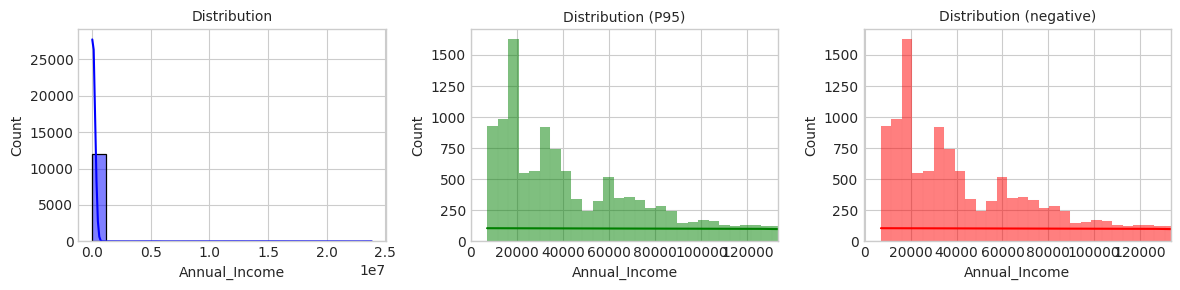


--- Column: Monthly_Inhand_Salary ---
Total Records: 12128
Missing: 0 (0.00%)
Non-Missing: 12128 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 303.65
Max: 15204.63
Skewness: 1.14
Kurtosis: 0.66
5th Percentile: 849.44
25th Percentile (Q1): 1604.15
75th Percentile (Q3): 5801.97
95th Percentile: 10358.75
Interquartile Range (IQR): 4197.82
IQR Outlier Bounds: -4692.58 to 12098.70
Outliers: 283 (2.33%)


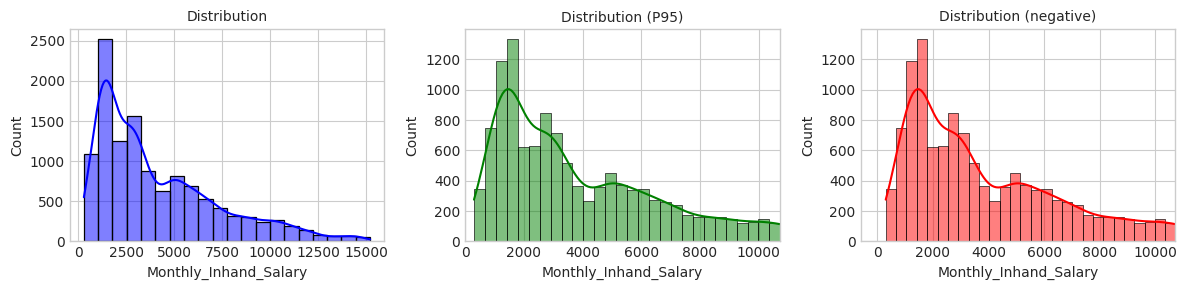


--- Column: Num_Bank_Accounts ---
Total Records: 12128
Missing: 0 (0.00%)
Non-Missing: 12128 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 0.00
Max: 1756.00
Skewness: 10.98
Kurtosis: 128.01
5th Percentile: 1.00
25th Percentile (Q1): 4.00
75th Percentile (Q3): 7.00
95th Percentile: 10.00
Interquartile Range (IQR): 3.00
IQR Outlier Bounds: -0.50 to 11.50
Outliers: 165 (1.36%)


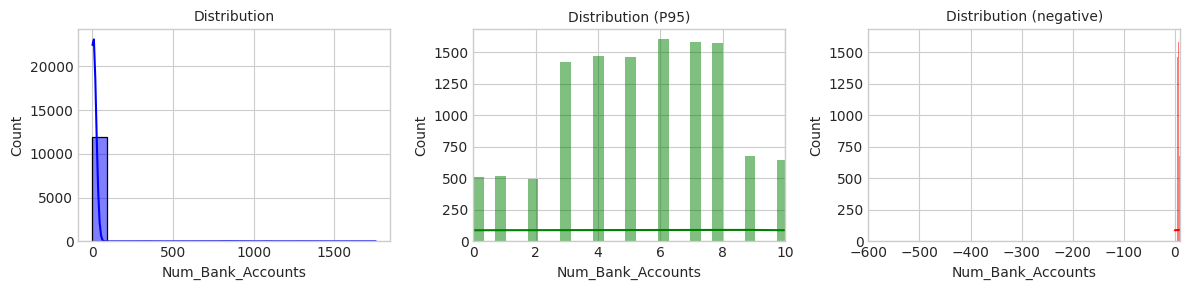


--- Column: Num_Credit_Card ---
Total Records: 12128
Missing: 0 (0.00%)
Non-Missing: 12128 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 0.00
Max: 1499.00
Skewness: 8.28
Kurtosis: 71.26
5th Percentile: 3.00
25th Percentile (Q1): 4.00
75th Percentile (Q3): 7.00
95th Percentile: 10.00
Interquartile Range (IQR): 3.00
IQR Outlier Bounds: -0.50 to 11.50
Outliers: 288 (2.37%)


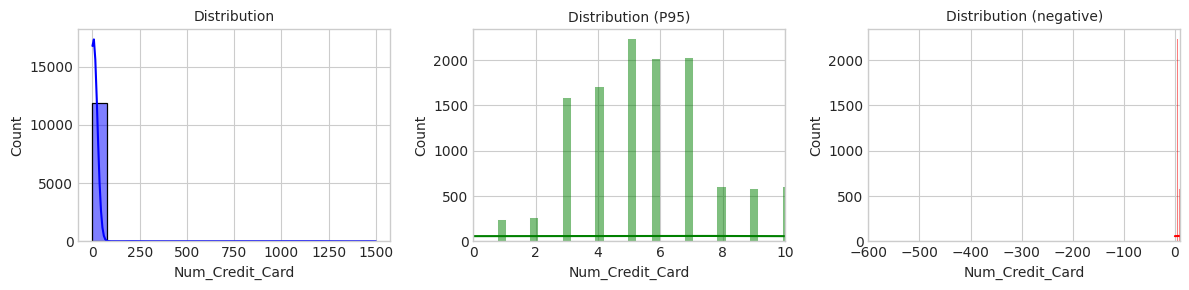


--- Column: Interest_Rate ---
Total Records: 12128
Missing: 0 (0.00%)
Non-Missing: 12128 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 1.00
Max: 5789.00
Skewness: 9.02
Kurtosis: 85.37
5th Percentile: 2.00
25th Percentile (Q1): 8.00
75th Percentile (Q3): 20.00
95th Percentile: 32.00
Interquartile Range (IQR): 12.00
IQR Outlier Bounds: -10.00 to 38.00
Outliers: 260 (2.14%)


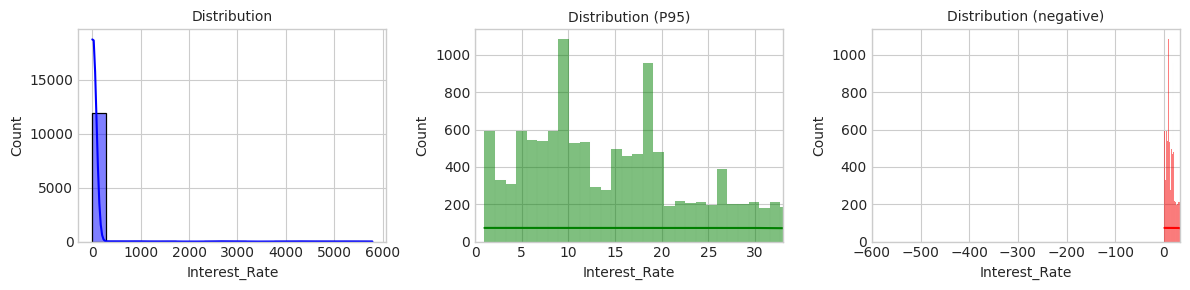


--- Column: Num_of_Loan ---
Total Records: 12128
Missing: 0 (0.00%)
Non-Missing: 12128 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 0.00
Max: 1171.00
Skewness: 75.41
Kurtosis: 6154.67
5th Percentile: 0.00
25th Percentile (Q1): 2.00
75th Percentile (Q3): 5.00
95th Percentile: 8.00
Interquartile Range (IQR): 3.00
IQR Outlier Bounds: -2.50 to 9.50
Outliers: 4 (0.03%)


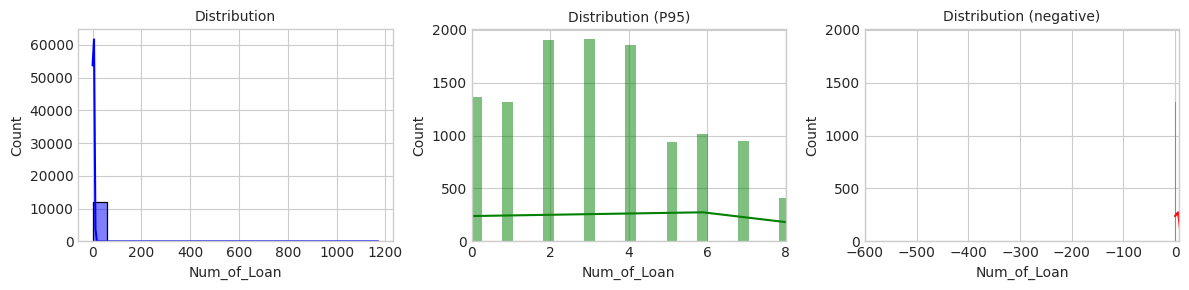


--- Column: Delay_from_due_date ---
Total Records: 12128
Missing: 0 (0.00%)
Non-Missing: 12128 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 0.00
Max: 67.00
Skewness: 0.97
Kurtosis: 0.33
5th Percentile: 3.00
25th Percentile (Q1): 10.00
75th Percentile (Q3): 28.00
95th Percentile: 52.00
Interquartile Range (IQR): 18.00
IQR Outlier Bounds: -17.00 to 55.00
Outliers: 496 (4.09%)


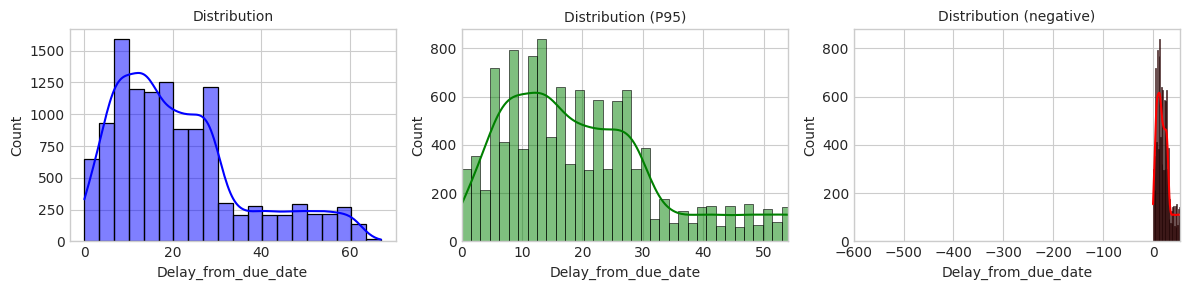


--- Column: Num_of_Delayed_Payment ---
Total Records: 12128
Missing: 0 (0.00%)
Non-Missing: 12128 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 0.00
Max: 4293.00
Skewness: 13.33
Kurtosis: 187.60
5th Percentile: 2.00
25th Percentile (Q1): 9.00
75th Percentile (Q3): 18.00
95th Percentile: 23.00
Interquartile Range (IQR): 9.00
IQR Outlier Bounds: -4.50 to 31.50
Outliers: 102 (0.84%)


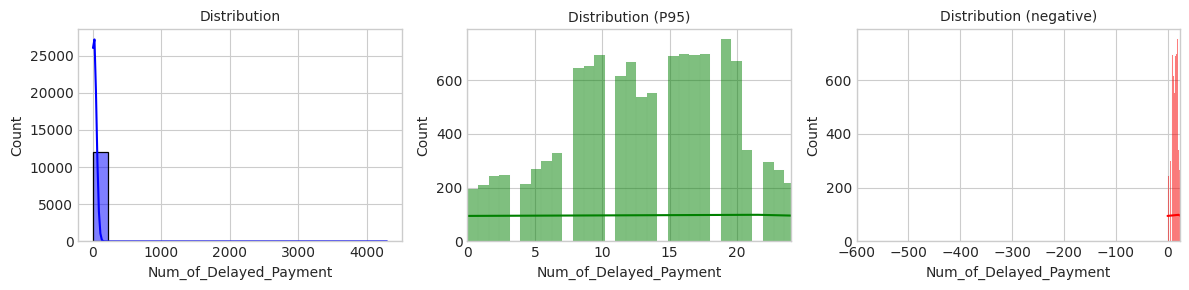


--- Column: Changed_Credit_Limit ---
Total Records: 12128
Missing: 0 (0.00%)
Non-Missing: 12128 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 0.00
Max: 36.97
Skewness: 0.68
Kurtosis: 0.03
5th Percentile: 1.08
25th Percentile (Q1): 5.23
75th Percentile (Q3): 14.66
95th Percentile: 22.49
Interquartile Range (IQR): 9.43
IQR Outlier Bounds: -8.91 to 28.80
Outliers: 122 (1.01%)


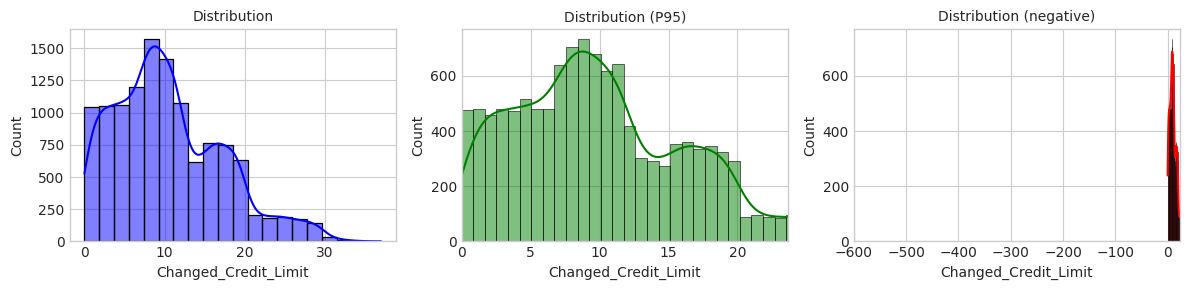


--- Column: Num_Credit_Inquiries ---
Total Records: 12128
Missing: 0 (0.00%)
Non-Missing: 12128 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 0.00
Max: 2554.00
Skewness: 10.27
Kurtosis: 110.45
5th Percentile: 1.00
25th Percentile (Q1): 4.00
75th Percentile (Q3): 10.00
95th Percentile: 14.00
Interquartile Range (IQR): 6.00
IQR Outlier Bounds: -5.00 to 19.00
Outliers: 187 (1.54%)


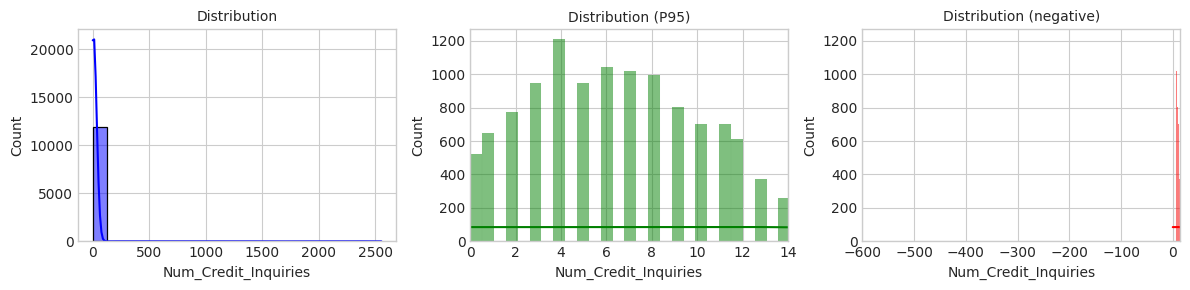


--- Column: Outstanding_Debt ---
Total Records: 12128
Missing: 0 (0.00%)
Non-Missing: 12128 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 0.23
Max: 4998.07
Skewness: 1.19
Kurtosis: 0.84
5th Percentile: 104.07
25th Percentile (Q1): 575.92
75th Percentile (Q3): 1928.03
95th Percentile: 3905.41
Interquartile Range (IQR): 1352.11
IQR Outlier Bounds: -1452.25 to 3956.20
Outliers: 693 (5.71%)


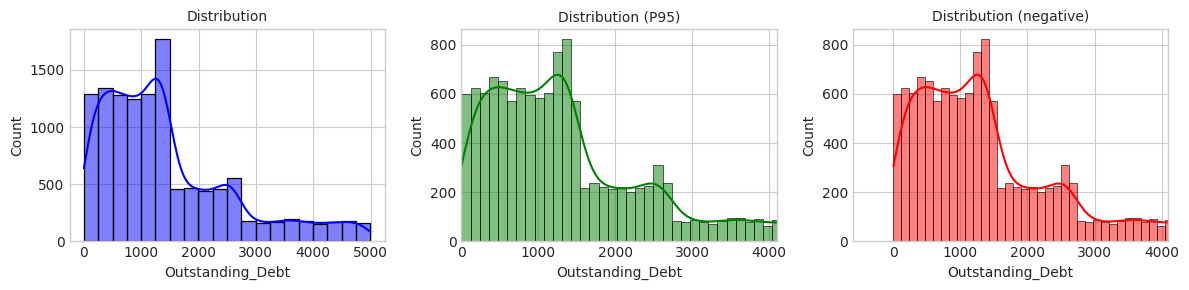


--- Column: Credit_Utilization_Ratio ---
Total Records: 12128
Missing: 0 (0.00%)
Non-Missing: 12128 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 0.20
Max: 0.48
Skewness: 0.00
Kurtosis: -0.97
5th Percentile: 0.24
25th Percentile (Q1): 0.28
75th Percentile (Q3): 0.36
95th Percentile: 0.40
Interquartile Range (IQR): 0.09
IQR Outlier Bounds: 0.15 to 0.49
Outliers: 0 (0.00%)


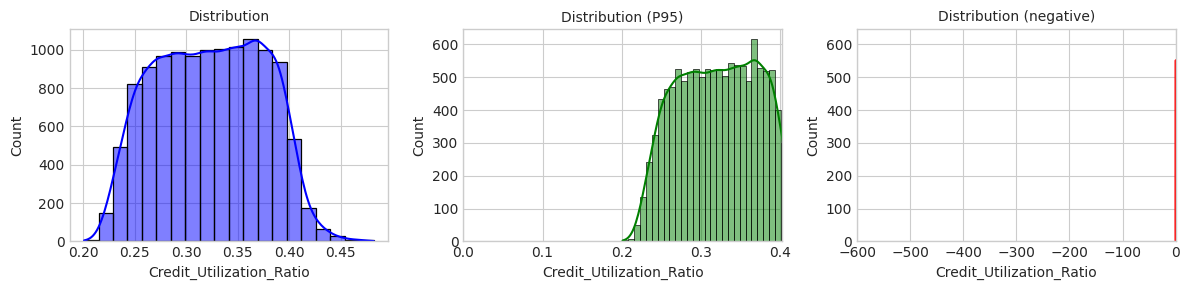


--- Column: Total_EMI_per_month ---
Total Records: 12128
Missing: 0 (0.00%)
Non-Missing: 12128 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 0.00
Max: 81971.00
Skewness: 6.93
Kurtosis: 49.63
5th Percentile: 0.00
25th Percentile (Q1): 31.20
75th Percentile (Q3): 165.79
95th Percentile: 455.87
Interquartile Range (IQR): 134.59
IQR Outlier Bounds: -170.68 to 367.67
Outliers: 931 (7.68%)


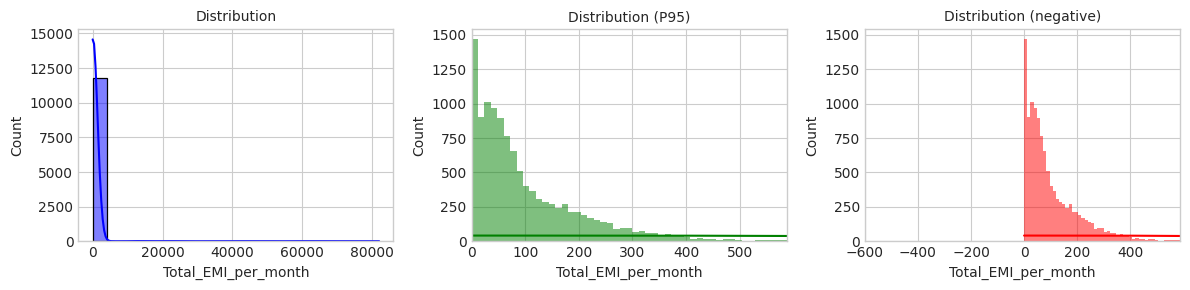


--- Column: Amount_invested_monthly ---
Total Records: 12128
Missing: 0 (0.00%)
Non-Missing: 12128 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 0.00
Max: 10000.00
Skewness: 4.33
Kurtosis: 16.97
5th Percentile: 31.74
25th Percentile (Q1): 73.56
75th Percentile (Q3): 252.28
95th Percentile: 901.87
Interquartile Range (IQR): 178.72
IQR Outlier Bounds: -194.53 to 520.36
Outliers: 1376 (11.35%)


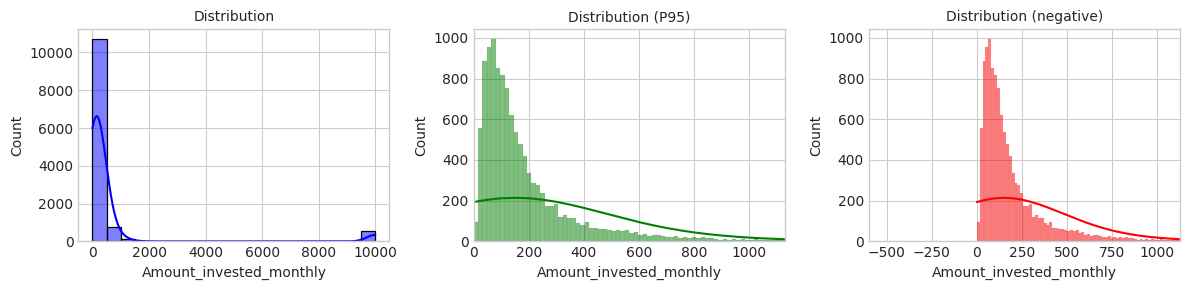


--- Column: Monthly_Balance ---
Total Records: 12128
Missing: 0 (0.00%)
Non-Missing: 12128 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 1 (0.01%)
+---------------+
|Monthly_Balance|
+---------------+
|  -3.3333333E26|
+---------------+


--- Statistics ---
Min: -333333329494718251244978176.00
Max: 1463.79
Skewness: -110.11
Kurtosis: 12123.00
5th Percentile: 165.71
25th Percentile (Q1): 268.89
75th Percentile (Q3): 463.56
95th Percentile: 824.25
Interquartile Range (IQR): 194.66
IQR Outlier Bounds: -23.10 to 755.55
Outliers: 974 (8.03%)
ERROR: Could not process the file. Details: Maximum allowed size exceeded


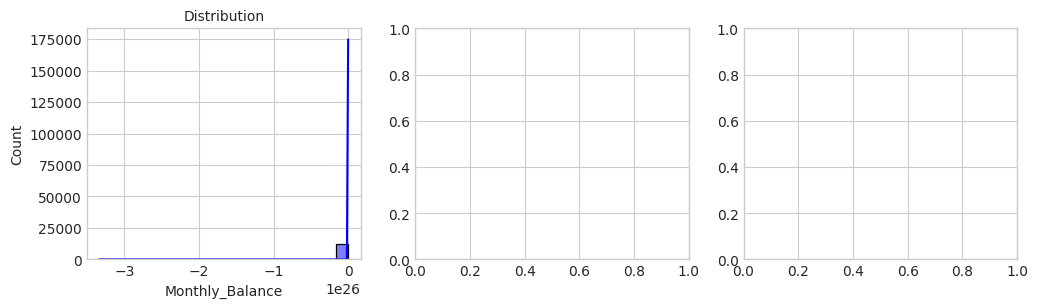

In [109]:
FILE_PATH = "datamart/silver/fe_financials/silver_features_financials*.parquet"
spark = SparkSession.builder.appName("EDA").getOrCreate()
spark.sparkContext.setLogLevel("WARN")

try:
    df = spark.read.parquet(FILE_PATH)
    print(f"--- EDA for: {FILE_PATH} ---")
    fields = ["Customer_ID","Type_of_Loan","Credit_Mix","Credit_History_Age","Payment_of_Min_Amount","Payment_Behaviour"]
    for field in fields:
        analyze_string_column(spark, df, field)
        show_duplicates(df, field)

    # --- Numeric Column ---
    fields = ["Annual_Income","Monthly_Inhand_Salary","Num_Bank_Accounts","Num_Credit_Card","Interest_Rate","Num_of_Loan","Delay_from_due_date","Num_of_Delayed_Payment",
              "Changed_Credit_Limit","Num_Credit_Inquiries","Outstanding_Debt","Credit_Utilization_Ratio","Total_EMI_per_month","Amount_invested_monthly","Monthly_Balance"]
    for field in fields:
        analyze_numeric_column(spark, df, field)

except Exception as e:
    print(f"ERROR: Could not process the file. Details: {e}")

spark.stop()

## Annual_Income Binning

25/10/04 13:02:33 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/10/04 13:02:33 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


--- Binning ---
+----------------------+-----+
|Annual_Income_Group_ID|count|
+----------------------+-----+
|                     1|   94|
|                     2|   92|
|                     3|  100|
|                     4|   82|
|                     5|   68|
|                     6|   37|
+----------------------+-----+



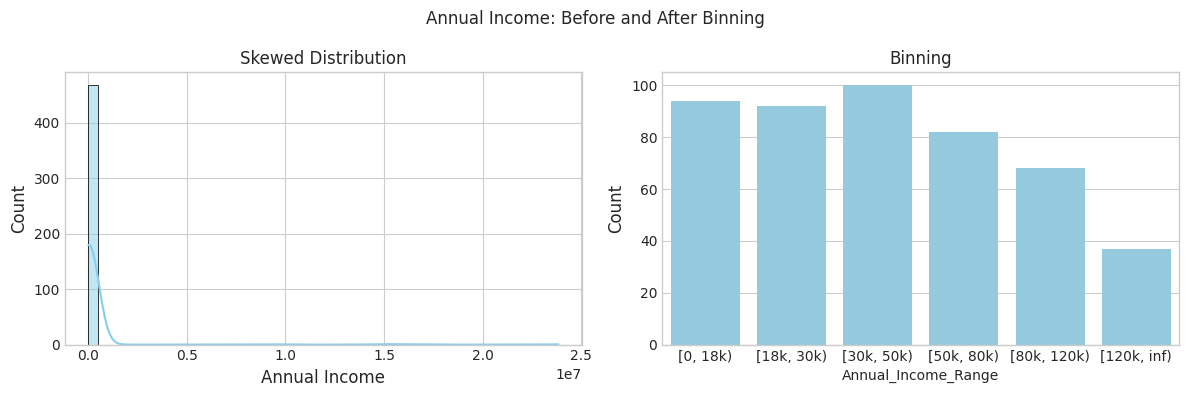

In [110]:
def create_bins(spark, df):
    print("--- Binning ---")
    # [1] Define the percentiles to use as bin boundaries.
    # percentiles = [0.20, 0.40, 0.60, 0.80, 0.95]
    
    # # [2] Calculate the actual threshold values from the DataFrame.
    # thresholds = df.approxQuantile("Annual_Income", percentiles, 0.01)
    
    # p20, p40, p60, p80, p95 = thresholds
    # print(f"Calculated Percentile Thresholds:")
    # print(f"  - 20th Percentile: {p20:.2f}")
    # print(f"  - 40th Percentile: {p40:.2f}")
    # print(f"  - 60th Percentile: {p60:.2f}")
    # print(f"  - 80th Percentile: {p80:.2f}")
    # print(f"  - 95th Percentile: {p95:.2f}")

    # [3] Use a chained 'when' expression to create the 'Annual_Income_Group_ID' column.
    # The conditions are applied in order.
    # df_binned = df.withColumn("Annual_Income_Group_ID",
    #     when(col("Annual_Income") <= p20, lit(1))
    #     .when(col("Annual_Income") <= p40, lit(2))
    #     .when(col("Annual_Income") <= p60, lit(3))
    #     .when(col("Annual_Income") <= p80, lit(4))
    #     .when(col("Annual_Income") <= p95, lit(5))
    #     .otherwise(lit(6)) # Anything above the 95th percentile
    # )
    
    # [4] Create a definition DataFrame for the bins
    # bin_definitions_data = [
    #     (1, f"<= {p20:.2f}"),
    #     (2, f"> {p20:.2f} and <= {p40:.2f}"),
    #     (3, f"> {p40:.2f} and <= {p60:.2f}"),
    #     (4, f"> {p60:.2f} and <= {p80:.2f}"),
    #     (5, f"> {p80:.2f} and <= {p95:.2f}"),
    #     (6, f"> {p95:.2f}")
    # ]
    
    ANNUAL_INCOME_GROUP = {
        1: 18000.0, # [0, 18k)
        2: 30000.0, # [18k, 30k)
        3: 50000.0, # [30k, 50k)
        4: 80000.0, # [50k, 80k)
        5: 120000.0, # [80k, 120k)
        6: float("inf") # [120k, inf)
    }
    df_binned = df.withColumn("Annual_Income_Group_ID",
        when(col("Annual_Income") < ANNUAL_INCOME_GROUP[1], lit(1))
        .when((col("Annual_Income") >= ANNUAL_INCOME_GROUP[1]) & (col("Annual_Income") < ANNUAL_INCOME_GROUP[2]), lit(2))
        .when((col("Annual_Income") >= ANNUAL_INCOME_GROUP[2]) & (col("Annual_Income") < ANNUAL_INCOME_GROUP[3]), lit(3))
        .when((col("Annual_Income") >= ANNUAL_INCOME_GROUP[3]) & (col("Annual_Income") < ANNUAL_INCOME_GROUP[4]), lit(4))
        .when((col("Annual_Income") >= ANNUAL_INCOME_GROUP[4]) & (col("Annual_Income") < ANNUAL_INCOME_GROUP[5]), lit(5))
        .otherwise(lit(6)) # Anything above the 95th percentile
    )
    
    bin_definitions_data = [
        (1, "[0, 18k)"),
        (2, "[18k, 30k)"),
        (3, "[30k, 50k)"),
        (4, "[50k, 80k)"),
        (5, "[80k, 120k)"),
        (6, "[120k, inf)"),
    ]
    
    bins_df = spark.createDataFrame(bin_definitions_data, ["Annual_Income_Group_ID", "Annual_Income_Range"])
    
    return df_binned.join(bins_df, on="Annual_Income_Group_ID", how="left")


def plot_income_distributions(raw_df, binned_df):
    try:
        # Prepare data for the "Before" plot (raw distribution)
        raw_pandas_df = raw_df.select("Annual_Income").toPandas().dropna()

        # Prepare data for the "After" plot (binned distribution)
        counts_df = binned_df.groupBy("Annual_Income_Range", "Annual_Income_Group_ID").count().orderBy("Annual_Income_Group_ID")
        binned_pandas_df = counts_df.toPandas()

        # Create a figure with two subplots, side-by-side
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        fig.suptitle('Annual Income: Before and After Binning', fontsize=12)

        # --- Left Plot: Raw Distribution ---
        sns.histplot(data=raw_pandas_df, x="Annual_Income", bins=50, kde=True, ax=axes[0], color='skyblue')
        axes[0].set_title('Skewed Distribution', fontsize=12)
        axes[0].set_xlabel('Annual Income', fontsize=12)
        axes[0].set_ylabel('Count', fontsize=12)
        # --- Right Plot: Binned Distribution ---
        sns.barplot(x="Annual_Income_Range", y="count", data=binned_pandas_df, ax=axes[1], color='skyblue')
        axes[1].set_title('Binning', fontsize=12)
        axes[1].set_ylabel('Count', fontsize=12)
        # axes[1].tick_params(axis='x', rotation=45)

        plt.tight_layout() 
        plt.show()
        plt.close()

    except Exception as e:
        print(f"Could not generate combined plot. Error: {e}")

FILE_PATH = "datamart/silver/fe_financials/silver_features_financials_2024_01_01.parquet"
spark = SparkSession.builder.appName("EDA").getOrCreate()
spark.sparkContext.setLogLevel("WARN")

try:
    df = spark.read.parquet(FILE_PATH)
    df_annual_income = create_bins(spark, df)
    df_annual_income.groupBy("Annual_Income_Group_ID").count().orderBy("Annual_Income_Group_ID").show() 
    plot_income_distributions(df, df_annual_income)

except Exception as e:
    print(f"ERROR: Could not process the file. Details: {e}")

spark.stop()

## Financials Quarantine Data Analysis

25/10/04 13:02:44 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/10/04 13:02:44 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


--- EDA for: datamart/silver/quarantine/quarantine_silver_features_financials*.parquet ---

--- Column: CUSTOMER_ID ---
Total Records: 372
Missing: 0 (0.00%)
Non-Missing: 372 (100.00%)
Distinct Values: 372 (100.00%)
Duplicates: 0 (0.00%)
Total duplicate rows beyond first occurrence: 0
Distinct Duplicates: 0 (0.00%)
No duplicate values found in this column.

--- Column: Type_of_Loan ---
Total Records: 372
Missing: 67 (18.01%)
Non-Missing: 305 (81.99%)
Distinct Values: 220 (59.14%)
Duplicates: 183 (49.19%)
Total duplicate rows beyond first occurrence: 152 (40.86%)
Distinct Duplicates: 31 (8.33%)
+---------------------------------------------------------+-----+
|Type_of_Loan                                             |count|
+---------------------------------------------------------+-----+
|NULL                                                     |67   |
|Auto Loan                                                |7    |
|Auto Loan, Home Equity Loan, and Personal Loan           |2    |
|Cr

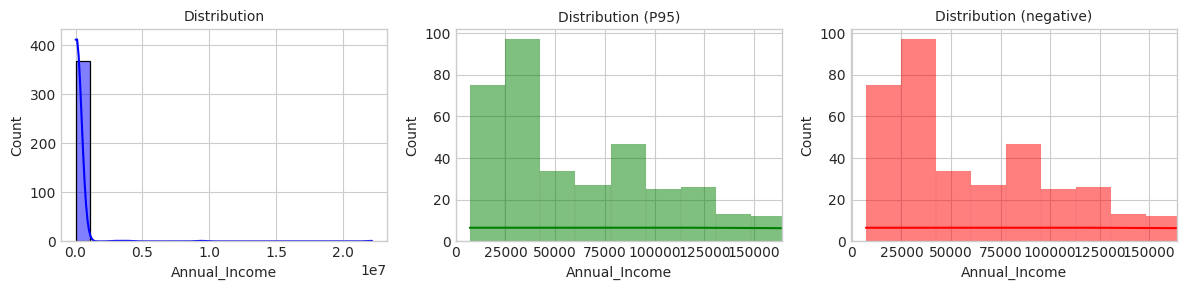


--- Column: Monthly_Inhand_Salary ---
Total Records: 372
Missing: 0 (0.00%)
Non-Missing: 372 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 467.34
Max: 15101.94
Skewness: 0.77
Kurtosis: -0.44
5th Percentile: 1083.97
25th Percentile (Q1): 2373.83
75th Percentile (Q3): 7755.88
95th Percentile: 13095.26
Interquartile Range (IQR): 5382.05
IQR Outlier Bounds: -5699.24 to 15828.94
Outliers: 0 (0.00%)


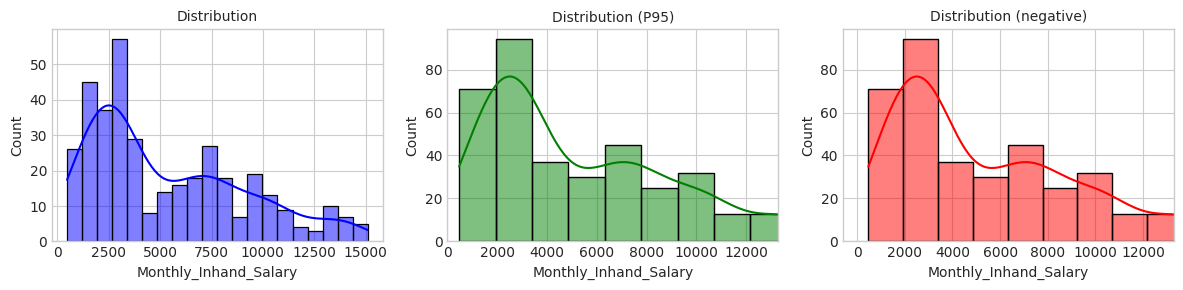


--- Column: Num_Bank_Accounts ---
Total Records: 372
Missing: 0 (0.00%)
Non-Missing: 372 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 4 (1.08%)
+-----------------+
|Num_Bank_Accounts|
+-----------------+
|               -1|
|               -1|
|               -1|
|               -1|
+-----------------+


--- Statistics ---
Min: -1.00
Max: 805.00
Skewness: 16.85
Kurtosis: 296.46
5th Percentile: 0.00
25th Percentile (Q1): 2.00
75th Percentile (Q3): 5.00
95th Percentile: 8.00
Interquartile Range (IQR): 3.00
IQR Outlier Bounds: -2.50 to 9.50
Outliers: 11 (2.96%)


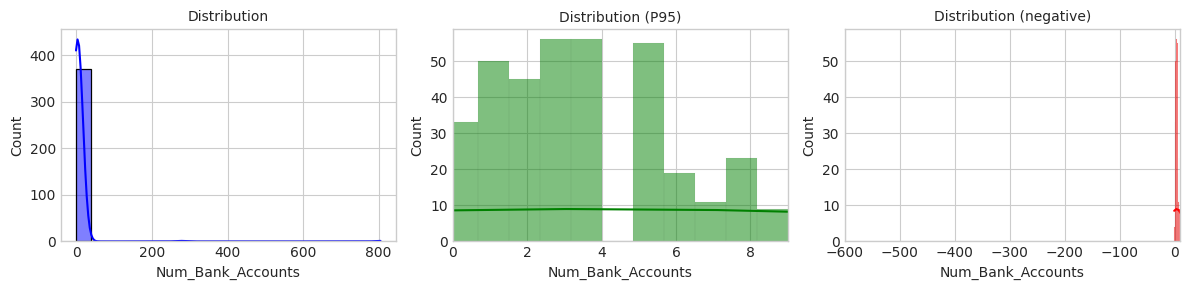


--- Column: Num_Credit_Card ---
Total Records: 372
Missing: 0 (0.00%)
Non-Missing: 372 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 1.00
Max: 1470.00
Skewness: 9.24
Kurtosis: 96.36
5th Percentile: 1.00
25th Percentile (Q1): 3.00
75th Percentile (Q3): 6.00
95th Percentile: 8.00
Interquartile Range (IQR): 3.00
IQR Outlier Bounds: -1.50 to 10.50
Outliers: 8 (2.15%)


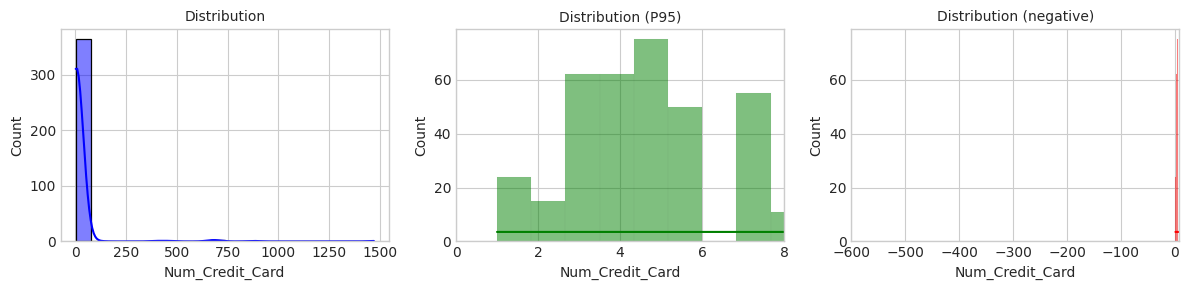


--- Column: Interest_Rate ---
Total Records: 372
Missing: 0 (0.00%)
Non-Missing: 372 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 1.00
Max: 5751.00
Skewness: 8.79
Kurtosis: 80.43
5th Percentile: 1.00
25th Percentile (Q1): 5.00
75th Percentile (Q3): 12.00
95th Percentile: 31.00
Interquartile Range (IQR): 7.00
IQR Outlier Bounds: -5.50 to 22.50
Outliers: 40 (10.75%)


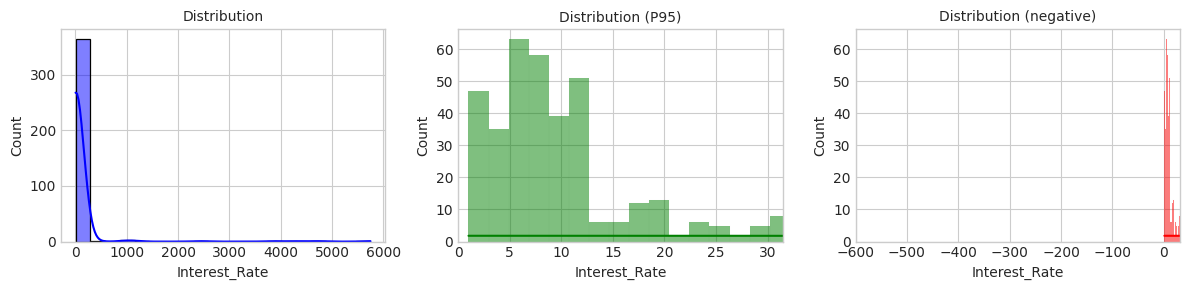


--- Column: Num_of_Loan ---
Total Records: 372
Missing: 0 (0.00%)
Non-Missing: 372 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 0.00
Max: 9.00
Skewness: 0.95
Kurtosis: 0.84
5th Percentile: 0.00
25th Percentile (Q1): 1.00
75th Percentile (Q3): 4.00
95th Percentile: 7.00
Interquartile Range (IQR): 3.00
IQR Outlier Bounds: -3.50 to 8.50
Outliers: 6 (1.61%)


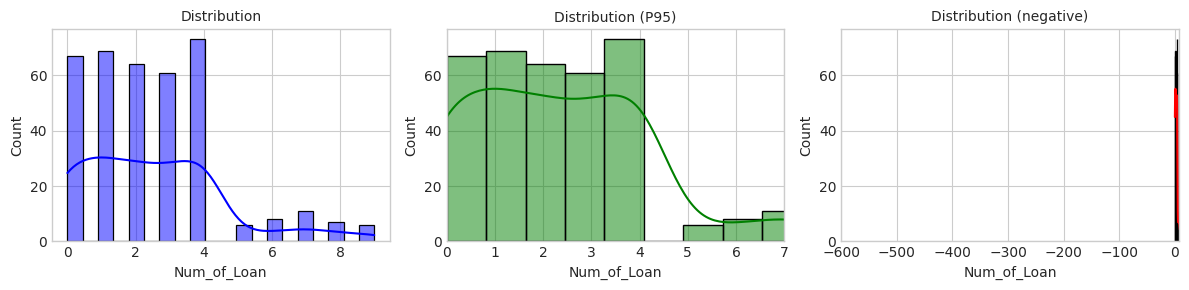


--- Column: Delay_from_due_date ---
Total Records: 372
Missing: 0 (0.00%)
Non-Missing: 372 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 88 (23.66%)
+-------------------+
|Delay_from_due_date|
+-------------------+
|                 -2|
|                 -1|
|                 -1|
|                 -3|
|                 -5|
+-------------------+
only showing top 5 rows


--- Statistics ---
Min: -5.00
Max: 62.00
Skewness: 1.44
Kurtosis: 2.28
5th Percentile: -4.00
25th Percentile (Q1): 0.00
75th Percentile (Q3): 17.00
95th Percentile: 42.00
Interquartile Range (IQR): 17.00
IQR Outlier Bounds: -25.50 to 42.50
Outliers: 20 (5.38%)


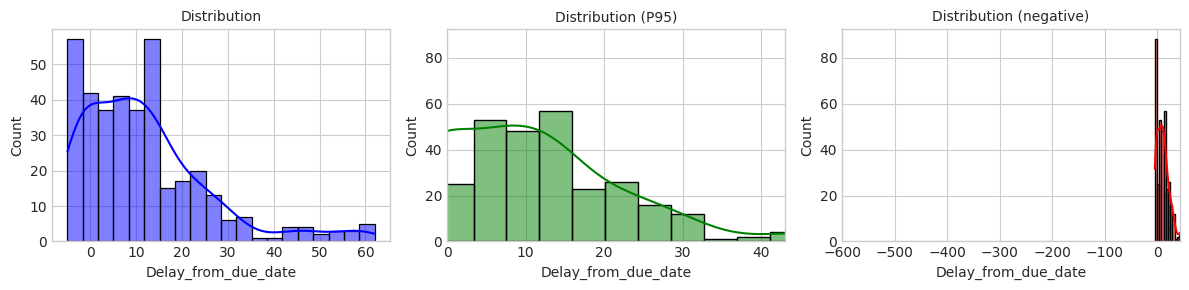


--- Column: Num_of_Delayed_Payment ---
Total Records: 372
Missing: 0 (0.00%)
Non-Missing: 372 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 84 (22.58%)
+----------------------+
|Num_of_Delayed_Payment|
+----------------------+
|                    -1|
|                    -3|
|                    -2|
|                    -2|
|                    -2|
+----------------------+
only showing top 5 rows


--- Statistics ---
Min: -3.00
Max: 3243.00
Skewness: 12.89
Kurtosis: 170.46
5th Percentile: -2.00
25th Percentile (Q1): 0.00
75th Percentile (Q3): 13.00
95th Percentile: 21.00
Interquartile Range (IQR): 13.00
IQR Outlier Bounds: -19.50 to 32.50
Outliers: 3 (0.81%)


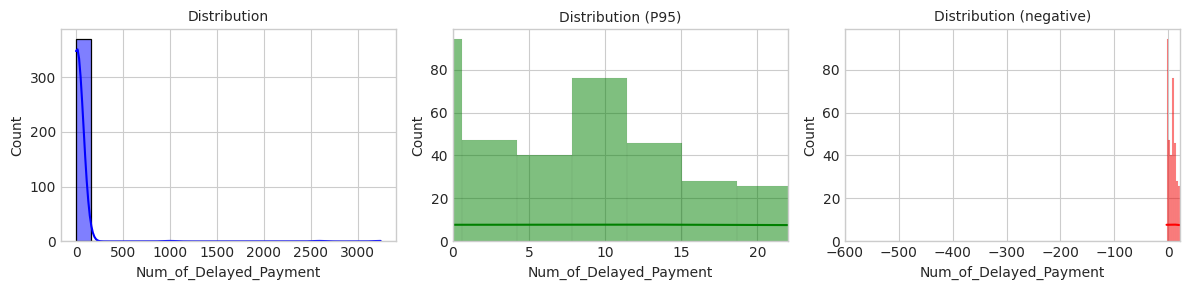


--- Column: Changed_Credit_Limit ---
Total Records: 372
Missing: 0 (0.00%)
Non-Missing: 372 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 204 (54.84%)
+--------------------+
|Changed_Credit_Limit|
+--------------------+
|               -4.52|
|               -4.26|
|                -3.5|
|               -2.12|
|               -4.36|
+--------------------+
only showing top 5 rows


--- Statistics ---
Min: -6.49
Max: 18.80
Skewness: 0.60
Kurtosis: -0.70
5th Percentile: -5.12
25th Percentile (Q1): -2.60
75th Percentile (Q3): 5.77
95th Percentile: 11.08
Interquartile Range (IQR): 8.37
IQR Outlier Bounds: -15.15 to 18.32
Outliers: 1 (0.27%)


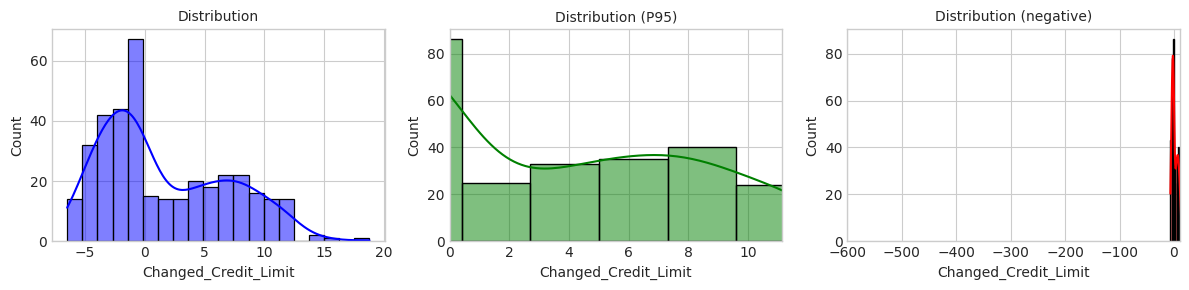


--- Column: Num_Credit_Inquiries ---
Total Records: 372
Missing: 0 (0.00%)
Non-Missing: 372 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 0.00
Max: 2389.00
Skewness: 8.06
Kurtosis: 69.16
5th Percentile: 1.00
25th Percentile (Q1): 2.00
75th Percentile (Q3): 6.00
95th Percentile: 12.00
Interquartile Range (IQR): 4.00
IQR Outlier Bounds: -4.00 to 12.00
Outliers: 18 (4.84%)


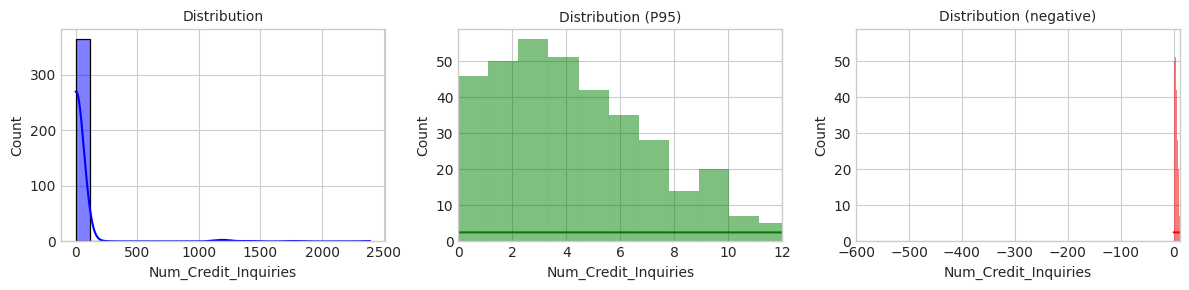


--- Column: Outstanding_Debt ---
Total Records: 372
Missing: 0 (0.00%)
Non-Missing: 372 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 5.67
Max: 4760.54
Skewness: 1.94
Kurtosis: 5.48
5th Percentile: 62.37
25th Percentile (Q1): 358.24
75th Percentile (Q3): 1205.60
95th Percentile: 2331.60
Interquartile Range (IQR): 847.36
IQR Outlier Bounds: -912.80 to 2476.64
Outliers: 16 (4.30%)


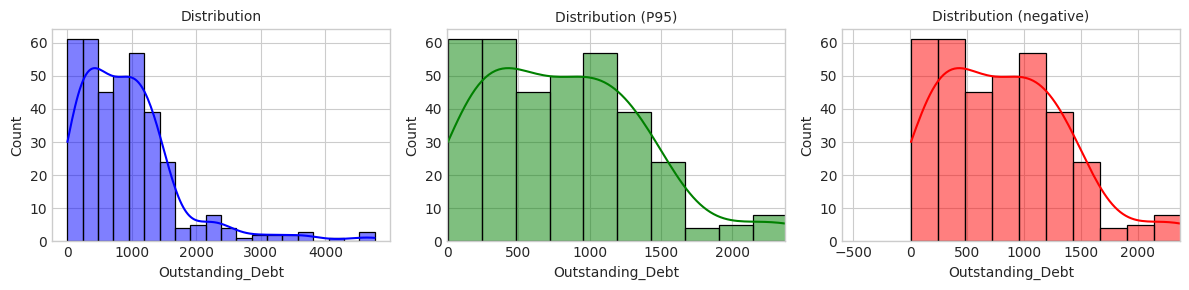


--- Column: Credit_Utilization_Ratio ---
Total Records: 372
Missing: 0 (0.00%)
Non-Missing: 372 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 22.10
Max: 45.98
Skewness: 0.03
Kurtosis: -0.97
5th Percentile: 24.03
25th Percentile (Q1): 27.89
75th Percentile (Q3): 36.80
95th Percentile: 40.82
Interquartile Range (IQR): 8.91
IQR Outlier Bounds: 14.53 to 50.16
Outliers: 0 (0.00%)


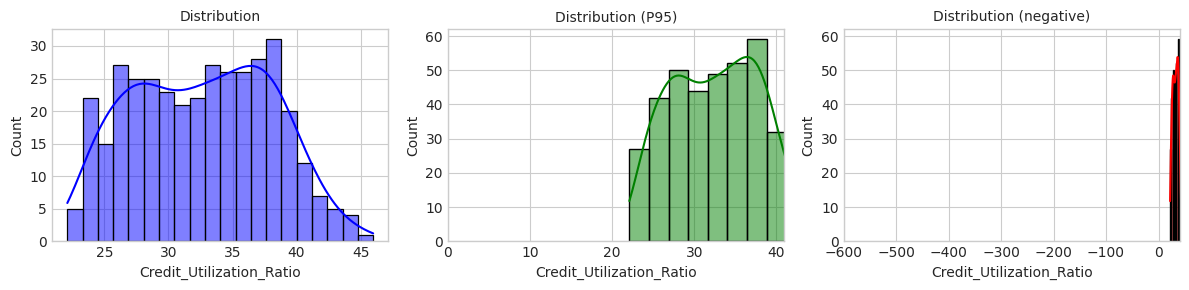


--- Column: Total_EMI_per_month ---
Total Records: 372
Missing: 0 (0.00%)
Non-Missing: 372 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 0.00
Max: 81760.00
Skewness: 6.97
Kurtosis: 51.43
5th Percentile: 0.00
25th Percentile (Q1): 21.48
75th Percentile (Q3): 175.92
95th Percentile: 604.64
Interquartile Range (IQR): 154.44
IQR Outlier Bounds: -210.18 to 407.57
Outliers: 34 (9.14%)


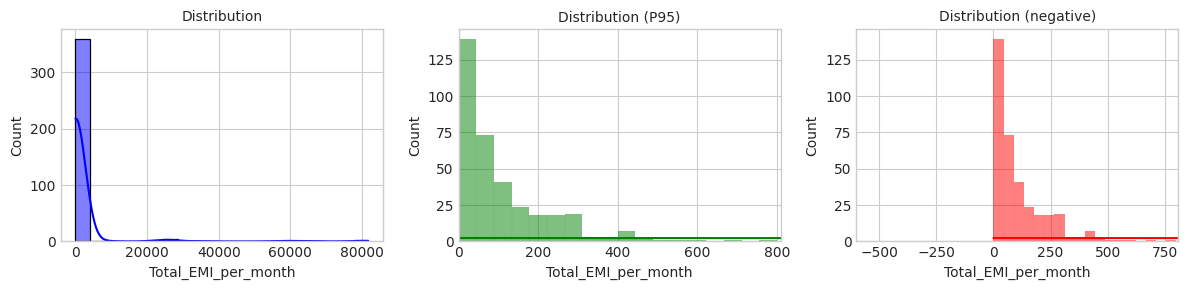


--- Column: Amount_invested_monthly ---
Total Records: 372
Missing: 0 (0.00%)
Non-Missing: 372 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 12.68
Max: 10000.00
Skewness: 4.75
Kurtosis: 20.94
5th Percentile: 39.88
25th Percentile (Q1): 83.01
75th Percentile (Q3): 318.90
95th Percentile: 876.35
Interquartile Range (IQR): 235.89
IQR Outlier Bounds: -270.83 to 672.74
Outliers: 32 (8.60%)


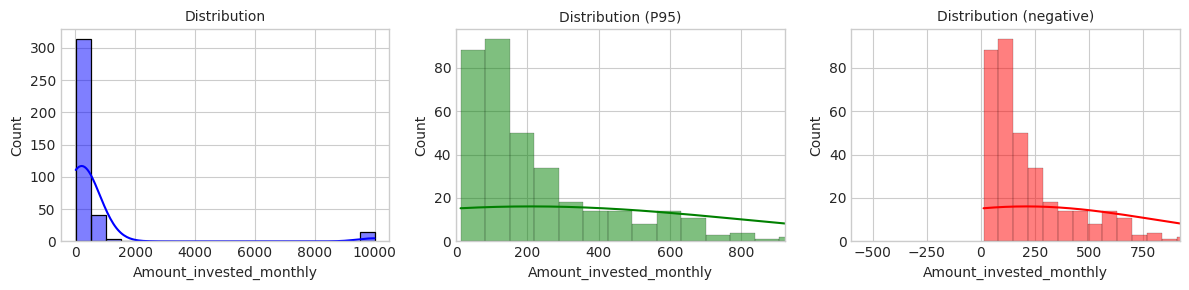


--- Column: Monthly_Balance ---
Total Records: 372
Missing: 0 (0.00%)
Non-Missing: 372 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 6.99
Max: 1446.95
Skewness: 1.15
Kurtosis: 1.00
5th Percentile: 201.43
25th Percentile (Q1): 293.56
75th Percentile (Q3): 595.31
95th Percentile: 999.67
Interquartile Range (IQR): 301.74
IQR Outlier Bounds: -159.05 to 1047.92
Outliers: 13 (3.49%)


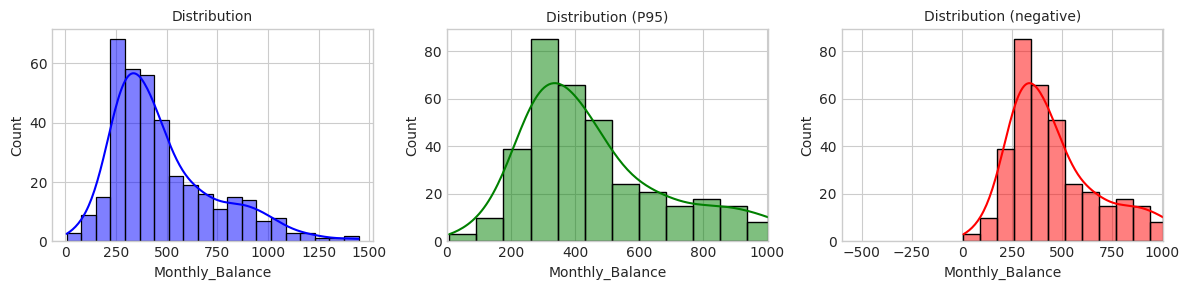

In [111]:
FILE_PATH = "datamart/silver/quarantine/quarantine_silver_features_financials*.parquet"
spark = SparkSession.builder.appName("EDA").getOrCreate()
spark.sparkContext.setLogLevel("WARN")

try:
    df = spark.read.parquet(FILE_PATH)
    
    print(f"--- EDA for: {FILE_PATH} ---")
    fields = ["CUSTOMER_ID","Type_of_Loan","Credit_Mix","Credit_History_Age","Payment_of_Min_Amount","Payment_Behaviour"]
    for field in fields:
        analyze_string_column(spark, df, field)
        show_duplicates(df, field)

    # --- Numeric Column ---
    fields = ["Annual_Income","Monthly_Inhand_Salary","Num_Bank_Accounts","Num_Credit_Card","Interest_Rate","Num_of_Loan","Delay_from_due_date","Num_of_Delayed_Payment",
              "Changed_Credit_Limit","Num_Credit_Inquiries","Outstanding_Debt","Credit_Utilization_Ratio","Total_EMI_per_month","Amount_invested_monthly","Monthly_Balance"]
    for field in fields:
        analyze_numeric_column(spark, df, field)

except Exception as e:
    print(f"ERROR: Could not process the file. Details: {e}")

spark.stop()

# Quarantine Data Analysis

In [112]:
import utils.helper_functions
import pyspark
from pyspark.sql.functions import col

spark = SparkSession.builder.appName("EDA").getOrCreate()
spark.sparkContext.setLogLevel("WARN")

quarantine_file = "datamart/silver/quarantine/quarantine_silver_features_attributes*.parquet" 
df_quarantine_attributes = utils.helper_functions.read_all_data(spark, quarantine_file)
df_quarantine_attributes.show(5, truncate=False) # 
utils.helper_functions.aggregate_quarantine_errors(df_quarantine_attributes,"errors")

quarantine_file = "datamart/silver/quarantine/quarantine_silver_features_financials*.parquet" 
df_quarantine_financials = utils.helper_functions.read_all_data(spark, quarantine_file)
df_quarantine_financials.show(5, truncate=False)
utils.helper_functions.aggregate_quarantine_errors(df_quarantine_financials,"errors")


25/10/04 13:03:20 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/10/04 13:03:20 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.



--- Reading all data from: datamart/silver/quarantine/quarantine_silver_features_attributes*.parquet ---
Successfully loaded a total of 988 records from all partitions.
+-----------+--------------+----+---------+----------+-------------+-----------------------+
|Customer_ID|Name          |Age |SSN      |Occupation|snapshot_date|errors                 |
+-----------+--------------+----+---------+----------+-------------+-----------------------+
|CUS_0x2e10 |Malonel       |15  |*****1417|Lawyer    |2024-06-01   |[AGE_OUT_OF_RANGE:15]  |
|CUS_0x72ce |Foo Yuna      |16  |*****4946|Teacher   |2024-06-01   |[AGE_OUT_OF_RANGE:16]  |
|CUS_0x82fa |Carrelg       |17  |*****8816|Missing   |2024-06-01   |[AGE_OUT_OF_RANGE:17]  |
|CUS_0x4866 |Gergelye      |16  |*****7699|Journalist|2024-06-01   |[AGE_OUT_OF_RANGE:16]  |
|CUS_0x434d |Sarah McBrideq|8229|*****3010|Musician  |2024-06-01   |[AGE_OUT_OF_RANGE:8229]|
+-----------+--------------+----+---------+----------+-------------+------------------

# Clickstream

## Clickstream CSV Data Analysis

--- EDA for: data/feature_clickstream.csv ---

--- Column: Customer_ID ---
Total Records: 215376
Missing: 0 (0.00%)
Non-Missing: 215376 (100.00%)
Distinct Values: 8974 (4.17%)
Duplicates: 215376 (100.00%)
Total duplicate rows beyond first occurrence: 206402 (95.83%)
Distinct Duplicates: 8974 (4.17%)
+-----------+-----+
|Customer_ID|count|
+-----------+-----+
|CUS_0x1000 |24   |
|CUS_0x100b |24   |
|CUS_0x1011 |24   |
|CUS_0x1013 |24   |
|CUS_0x1015 |24   |
|CUS_0x1018 |24   |
|CUS_0x1026 |24   |
|CUS_0x102d |24   |
|CUS_0x102e |24   |
|CUS_0x1032 |24   |
|CUS_0x1037 |24   |
|CUS_0x1041 |24   |
|CUS_0x1044 |24   |
|CUS_0x1048 |24   |
|CUS_0x104a |24   |
|CUS_0x104e |24   |
|CUS_0x1051 |24   |
|CUS_0x1056 |24   |
|CUS_0x1057 |24   |
|CUS_0x105b |24   |
+-----------+-----+
only showing top 20 rows


--- Column: fe_1 ---
Total Records: 215376
Missing: 0 (0.00%)
Non-Missing: 215376 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 33159 (15.40%)
+----+
|fe_1|
+----+
|-108|
| -13|
| -

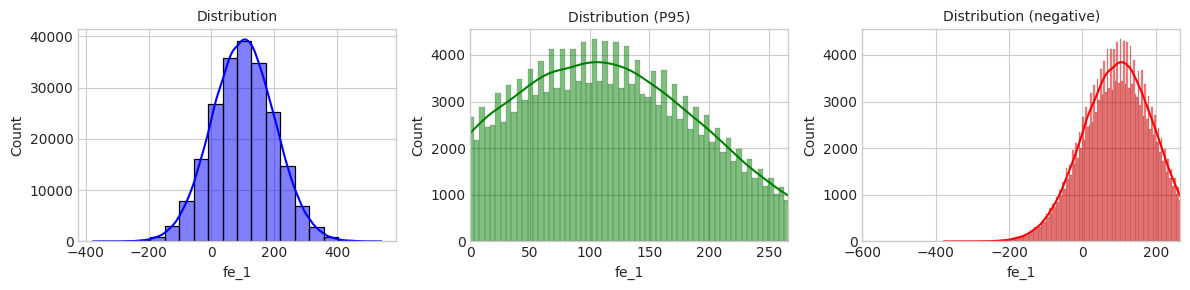


--- Column: fe_2 ---
Total Records: 215376
Missing: 0 (0.00%)
Non-Missing: 215376 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 32170 (14.94%)
+----+
|fe_2|
+----+
| -23|
| -15|
|-106|
| -86|
|  -1|
+----+
only showing top 5 rows


--- Statistics ---
Min: -356.00
Max: 560.00
Skewness: -0.00
Kurtosis: -0.01
5th Percentile: -55.00
25th Percentile (Q1): 33.00
75th Percentile (Q3): 168.00
95th Percentile: 259.00
Interquartile Range (IQR): 135.00
IQR Outlier Bounds: -169.50 to 370.50
Outliers: 1464 (0.68%)


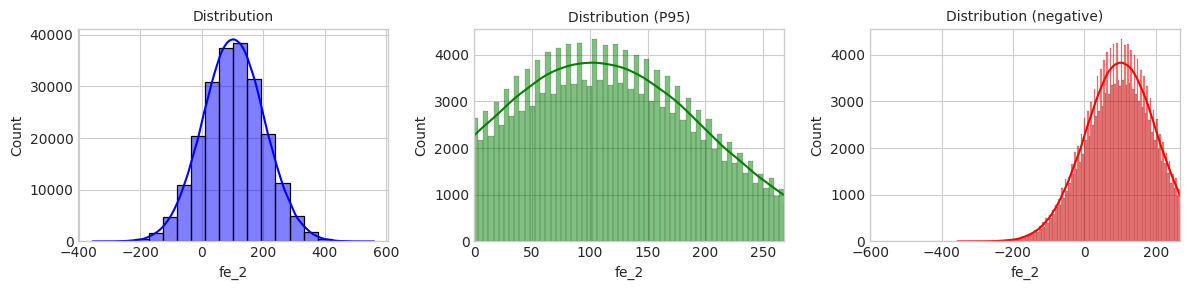


--- Column: fe_3 ---
Total Records: 215376
Missing: 0 (0.00%)
Non-Missing: 215376 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 32079 (14.89%)
+----+
|fe_3|
+----+
|  -4|
| -98|
| -27|
| -70|
| -14|
+----+
only showing top 5 rows


--- Statistics ---
Min: -399.00
Max: 583.00
Skewness: 0.00
Kurtosis: 0.00
5th Percentile: -56.00
25th Percentile (Q1): 36.00
75th Percentile (Q3): 170.00
95th Percentile: 262.00
Interquartile Range (IQR): 134.00
IQR Outlier Bounds: -165.00 to 371.00
Outliers: 1629 (0.76%)


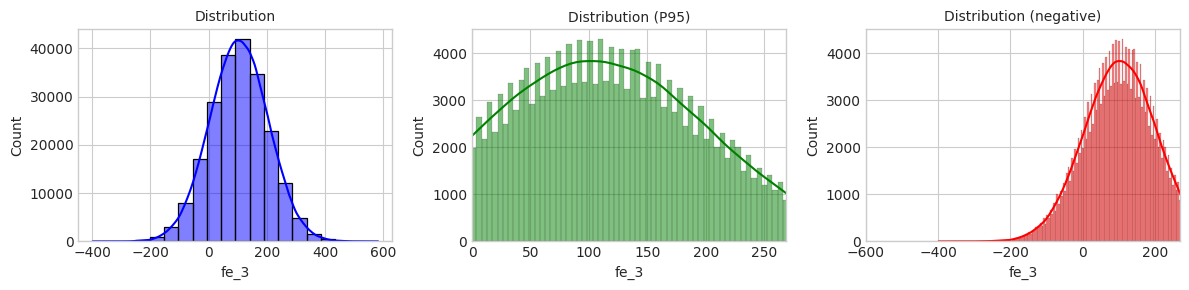


--- Column: fe_4 ---
Total Records: 215376
Missing: 0 (0.00%)
Non-Missing: 215376 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 31150 (14.46%)
+----+
|fe_4|
+----+
| -86|
| -16|
|  -1|
| -46|
| -18|
+----+
only showing top 5 rows


--- Statistics ---
Min: -307.00
Max: 562.00
Skewness: -0.00
Kurtosis: -0.00
5th Percentile: -54.00
25th Percentile (Q1): 39.00
75th Percentile (Q3): 171.00
95th Percentile: 263.00
Interquartile Range (IQR): 132.00
IQR Outlier Bounds: -159.00 to 369.00
Outliers: 1834 (0.85%)


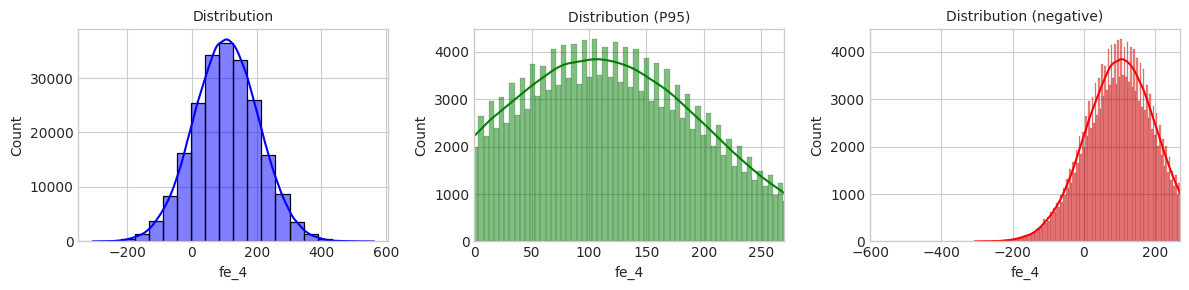


--- Column: fe_5 ---
Total Records: 215376
Missing: 0 (0.00%)
Non-Missing: 215376 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 30734 (14.27%)
+----+
|fe_5|
+----+
| -56|
| -34|
| -87|
| -10|
|  -6|
+----+
only showing top 5 rows


--- Statistics ---
Min: -343.00
Max: 570.00
Skewness: -0.01
Kurtosis: 0.01
5th Percentile: -54.00
25th Percentile (Q1): 40.00
75th Percentile (Q3): 173.00
95th Percentile: 264.00
Interquartile Range (IQR): 133.00
IQR Outlier Bounds: -159.50 to 372.50
Outliers: 1784 (0.83%)


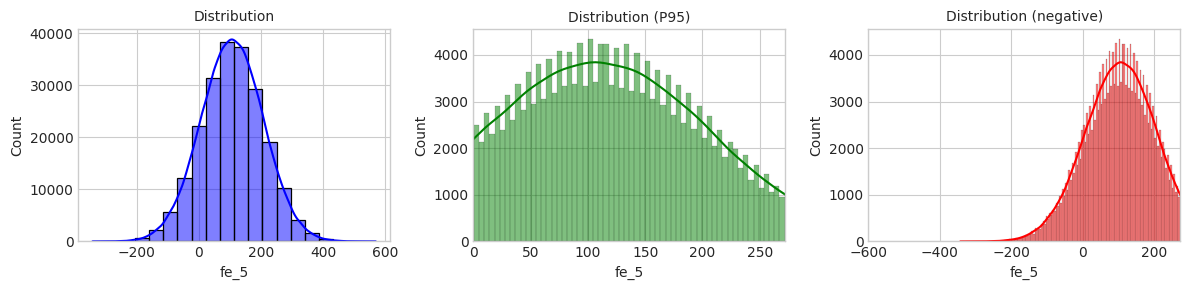


--- Column: fe_6 ---
Total Records: 215376
Missing: 0 (0.00%)
Non-Missing: 215376 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 32353 (15.02%)
+----+
|fe_6|
+----+
| -98|
| -60|
|-147|
| -18|
|-134|
+----+
only showing top 5 rows


--- Statistics ---
Min: -321.00
Max: 565.00
Skewness: 0.01
Kurtosis: -0.02
5th Percentile: -56.00
25th Percentile (Q1): 35.00
75th Percentile (Q3): 169.00
95th Percentile: 260.00
Interquartile Range (IQR): 134.00
IQR Outlier Bounds: -166.00 to 370.00
Outliers: 1584 (0.74%)


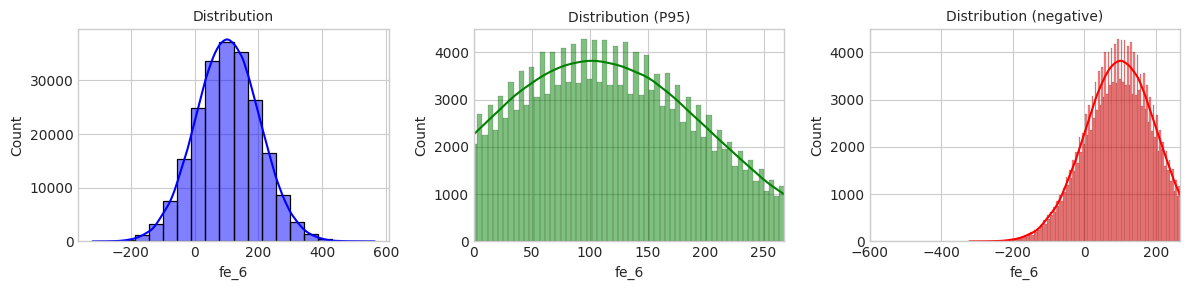


--- Column: fe_7 ---
Total Records: 215376
Missing: 0 (0.00%)
Non-Missing: 215376 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 30479 (14.15%)
+----+
|fe_7|
+----+
|-129|
|  -6|
|  -1|
| -18|
| -58|
+----+
only showing top 5 rows


--- Statistics ---
Min: -368.00
Max: 537.00
Skewness: 0.00
Kurtosis: 0.02
5th Percentile: -54.00
25th Percentile (Q1): 37.00
75th Percentile (Q3): 173.00
95th Percentile: 265.00
Interquartile Range (IQR): 136.00
IQR Outlier Bounds: -167.00 to 377.00
Outliers: 1413 (0.66%)


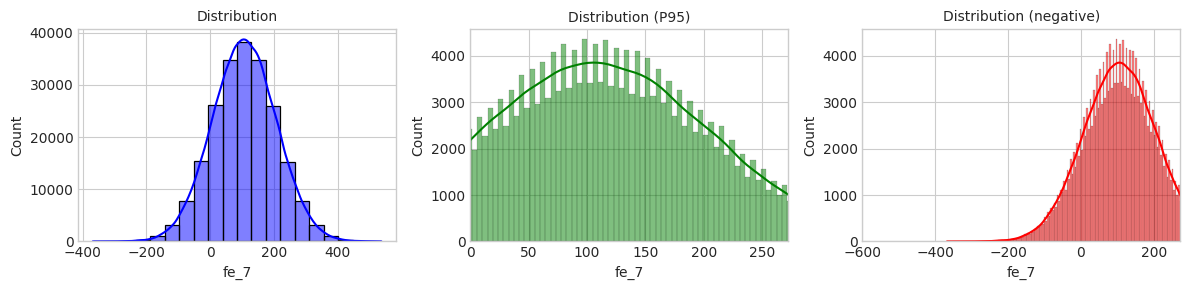


--- Column: fe_8 ---
Total Records: 215376
Missing: 0 (0.00%)
Non-Missing: 215376 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 28891 (13.41%)
+----+
|fe_8|
+----+
|  -6|
| -61|
| -60|
| -20|
| -20|
+----+
only showing top 5 rows


--- Statistics ---
Min: -361.00
Max: 573.00
Skewness: 0.00
Kurtosis: -0.00
5th Percentile: -49.00
25th Percentile (Q1): 41.00
75th Percentile (Q3): 176.00
95th Percentile: 267.00
Interquartile Range (IQR): 135.00
IQR Outlier Bounds: -161.50 to 378.50
Outliers: 1542 (0.72%)


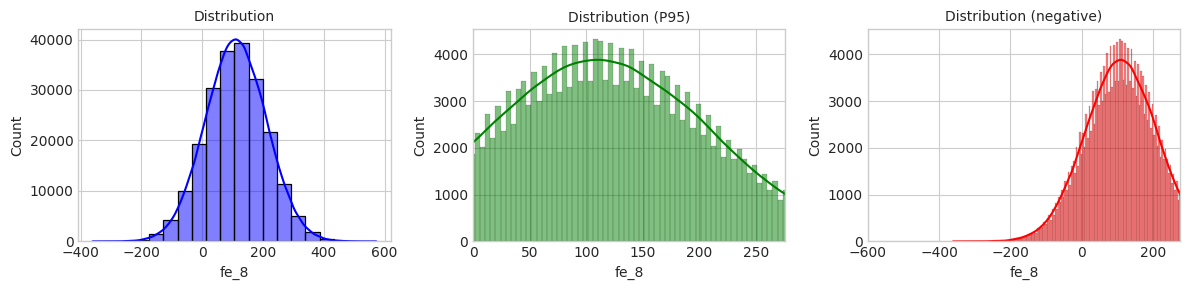


--- Column: fe_9 ---
Total Records: 215376
Missing: 0 (0.00%)
Non-Missing: 215376 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 27224 (12.64%)
+----+
|fe_9|
+----+
|-101|
| -64|
|-144|
| -13|
| -17|
+----+
only showing top 5 rows


--- Statistics ---
Min: -328.00
Max: 577.00
Skewness: -0.00
Kurtosis: -0.01
5th Percentile: -46.00
25th Percentile (Q1): 47.00
75th Percentile (Q3): 180.00
95th Percentile: 270.00
Interquartile Range (IQR): 133.00
IQR Outlier Bounds: -152.50 to 379.50
Outliers: 1715 (0.80%)


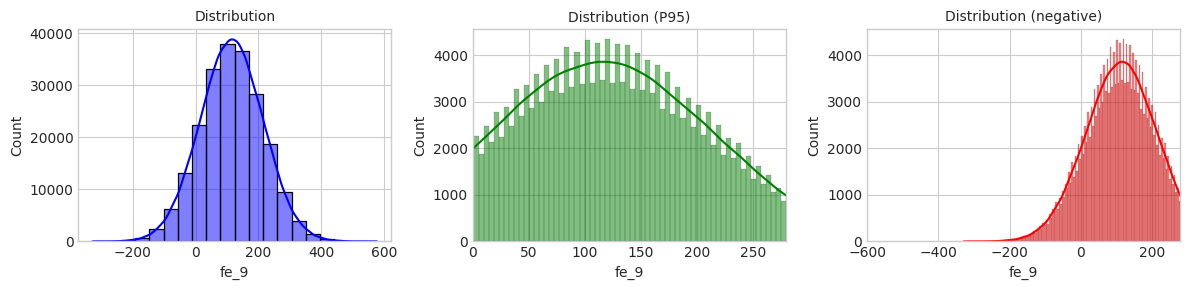


--- Column: fe_10 ---
Total Records: 215376
Missing: 0 (0.00%)
Non-Missing: 215376 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 25995 (12.07%)
+-----+
|fe_10|
+-----+
| -207|
|  -69|
|  -53|
|  -12|
|  -53|
+-----+
only showing top 5 rows


--- Statistics ---
Min: -317.00
Max: 537.00
Skewness: 0.00
Kurtosis: 0.01
5th Percentile: -43.00
25th Percentile (Q1): 48.00
75th Percentile (Q3): 183.00
95th Percentile: 275.00
Interquartile Range (IQR): 135.00
IQR Outlier Bounds: -154.50 to 385.50
Outliers: 1595 (0.74%)


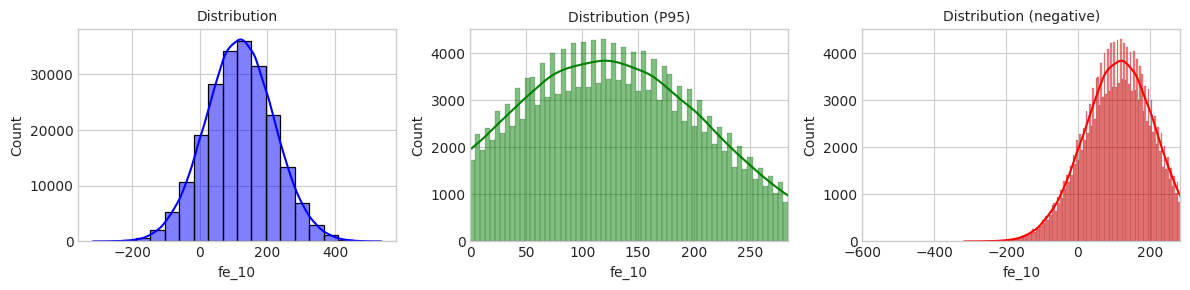


--- Column: fe_11 ---
Total Records: 215376
Missing: 0 (0.00%)
Non-Missing: 215376 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 34235 (15.90%)
+-----+
|fe_11|
+-----+
|  -70|
|  -33|
|  -80|
|  -48|
|  -42|
+-----+
only showing top 5 rows


--- Statistics ---
Min: -375.00
Max: 613.00
Skewness: 0.00
Kurtosis: 0.02
5th Percentile: -60.00
25th Percentile (Q1): 32.00
75th Percentile (Q3): 165.00
95th Percentile: 257.00
Interquartile Range (IQR): 133.00
IQR Outlier Bounds: -167.50 to 364.50
Outliers: 1769 (0.82%)


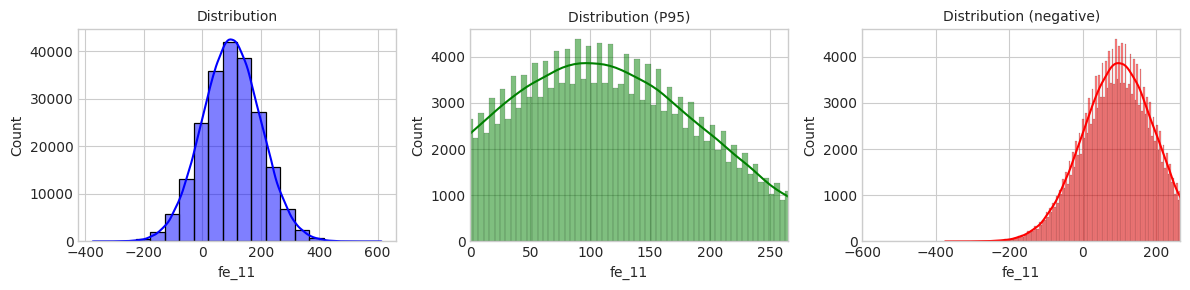


--- Column: fe_12 ---
Total Records: 215376
Missing: 0 (0.00%)
Non-Missing: 215376 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 34194 (15.88%)
+-----+
|fe_12|
+-----+
| -138|
|  -75|
|   -8|
|   -3|
|  -44|
+-----+
only showing top 5 rows


--- Statistics ---
Min: -344.00
Max: 550.00
Skewness: -0.01
Kurtosis: -0.01
5th Percentile: -60.00
25th Percentile (Q1): 30.00
75th Percentile (Q3): 166.00
95th Percentile: 258.00
Interquartile Range (IQR): 136.00
IQR Outlier Bounds: -174.00 to 370.00
Outliers: 1428 (0.66%)


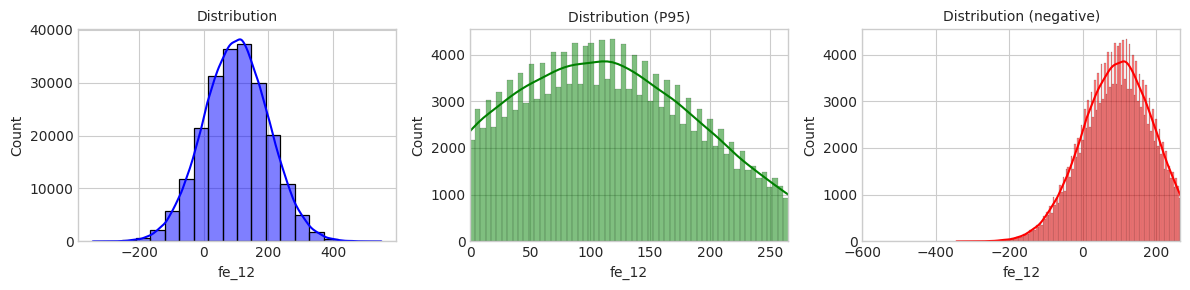


--- Column: fe_13 ---
Total Records: 215376
Missing: 0 (0.00%)
Non-Missing: 215376 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 34137 (15.85%)
+-----+
|fe_13|
+-----+
|  -16|
|  -14|
|   -1|
|  -49|
| -131|
+-----+
only showing top 5 rows


--- Statistics ---
Min: -355.00
Max: 530.00
Skewness: -0.01
Kurtosis: 0.01
5th Percentile: -60.00
25th Percentile (Q1): 33.00
75th Percentile (Q3): 166.00
95th Percentile: 258.00
Interquartile Range (IQR): 133.00
IQR Outlier Bounds: -166.50 to 365.50
Outliers: 1778 (0.83%)


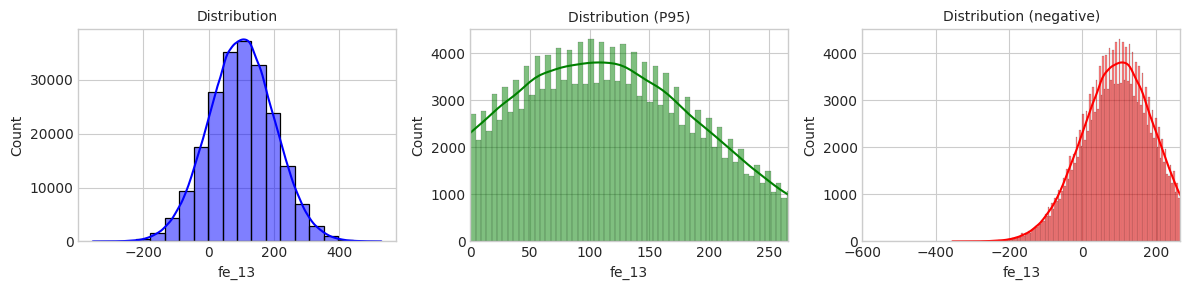


--- Column: fe_14 ---
Total Records: 215376
Missing: 0 (0.00%)
Non-Missing: 215376 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 34541 (16.04%)
+-----+
|fe_14|
+-----+
|  -81|
|  -96|
|  -61|
|  -26|
|  -40|
+-----+
only showing top 5 rows


--- Statistics ---
Min: -394.00
Max: 583.00
Skewness: 0.00
Kurtosis: 0.00
5th Percentile: -62.00
25th Percentile (Q1): 32.00
75th Percentile (Q3): 166.00
95th Percentile: 261.00
Interquartile Range (IQR): 134.00
IQR Outlier Bounds: -169.00 to 367.00
Outliers: 1713 (0.80%)


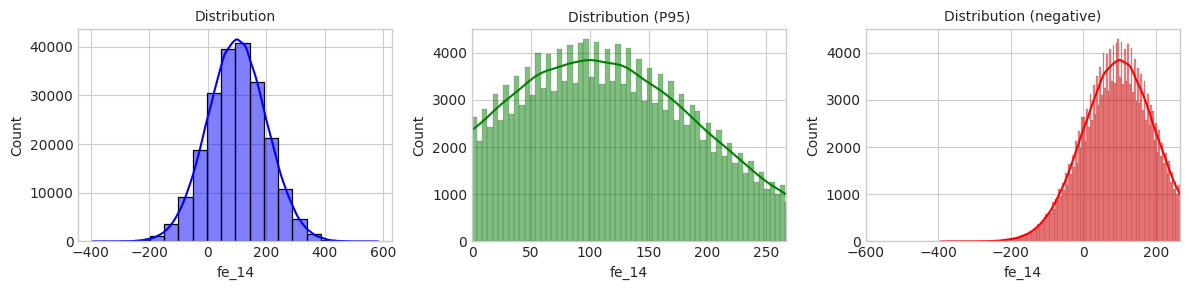


--- Column: fe_15 ---
Total Records: 215376
Missing: 0 (0.00%)
Non-Missing: 215376 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 34778 (16.15%)
+-----+
|fe_15|
+-----+
| -126|
|  -46|
|  -64|
|  -23|
| -124|
+-----+
only showing top 5 rows


--- Statistics ---
Min: -351.00
Max: 597.00
Skewness: -0.01
Kurtosis: -0.00
5th Percentile: -61.00
25th Percentile (Q1): 31.00
75th Percentile (Q3): 166.00
95th Percentile: 258.00
Interquartile Range (IQR): 135.00
IQR Outlier Bounds: -171.50 to 368.50
Outliers: 1610 (0.75%)


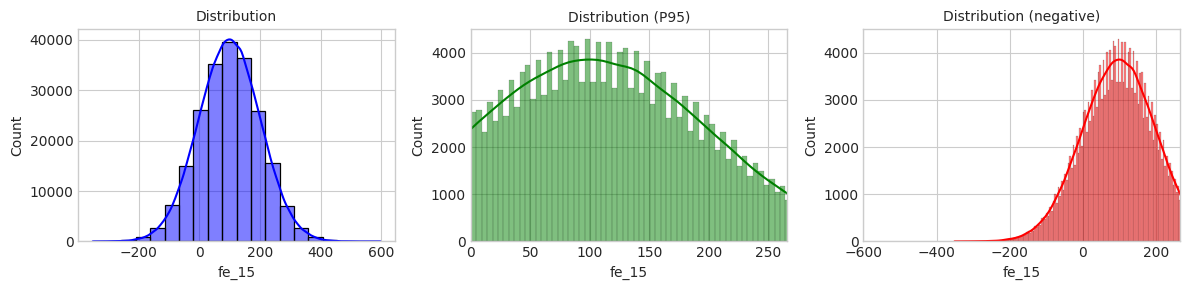


--- Column: fe_16 ---
Total Records: 215376
Missing: 0 (0.00%)
Non-Missing: 215376 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 34318 (15.93%)
+-----+
|fe_16|
+-----+
|  -85|
| -168|
|   -7|
|  -25|
|  -25|
+-----+
only showing top 5 rows


--- Statistics ---
Min: -342.00
Max: 554.00
Skewness: -0.01
Kurtosis: -0.00
5th Percentile: -61.00
25th Percentile (Q1): 30.00
75th Percentile (Q3): 166.00
95th Percentile: 257.00
Interquartile Range (IQR): 136.00
IQR Outlier Bounds: -174.00 to 370.00
Outliers: 1453 (0.67%)


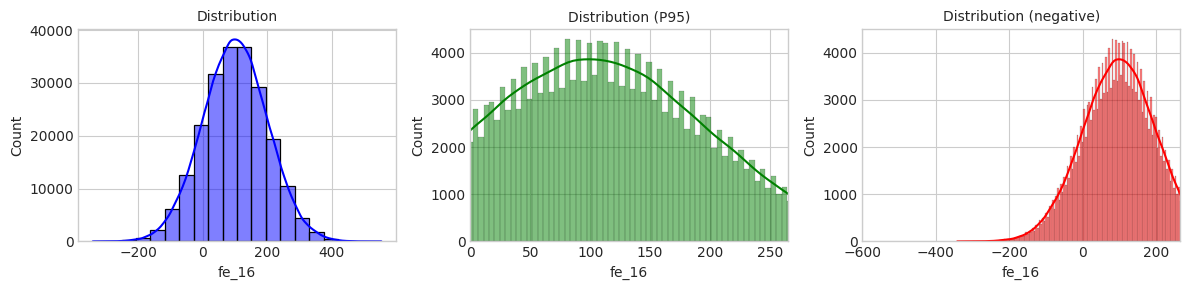


--- Column: fe_17 ---
Total Records: 215376
Missing: 0 (0.00%)
Non-Missing: 215376 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 34460 (16.00%)
+-----+
|fe_17|
+-----+
| -130|
|  -26|
|  -72|
| -180|
|  -59|
+-----+
only showing top 5 rows


--- Statistics ---
Min: -329.00
Max: 516.00
Skewness: -0.00
Kurtosis: 0.00
5th Percentile: -62.00
25th Percentile (Q1): 29.00
75th Percentile (Q3): 166.00
95th Percentile: 258.00
Interquartile Range (IQR): 137.00
IQR Outlier Bounds: -176.50 to 371.50
Outliers: 1508 (0.70%)


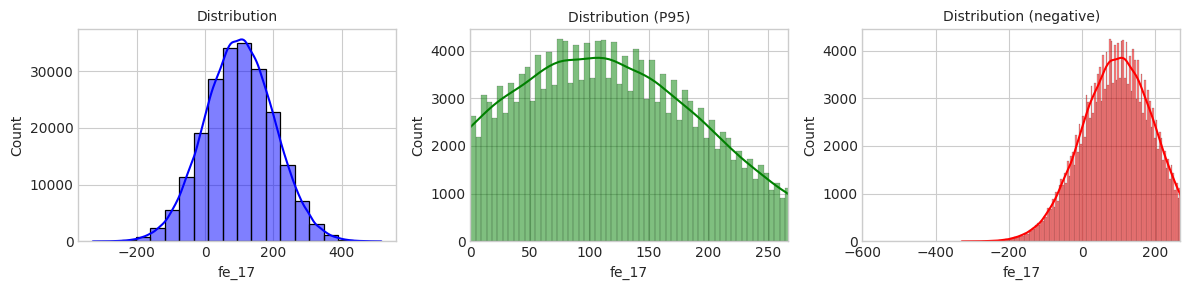


--- Column: fe_18 ---
Total Records: 215376
Missing: 0 (0.00%)
Non-Missing: 215376 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 34733 (16.13%)
+-----+
|fe_18|
+-----+
|  -74|
|  -86|
|  -32|
|  -84|
| -105|
+-----+
only showing top 5 rows


--- Statistics ---
Min: -344.00
Max: 551.00
Skewness: -0.01
Kurtosis: -0.00
5th Percentile: -63.00
25th Percentile (Q1): 31.00
75th Percentile (Q3): 167.00
95th Percentile: 261.00
Interquartile Range (IQR): 136.00
IQR Outlier Bounds: -173.00 to 371.00
Outliers: 1640 (0.76%)


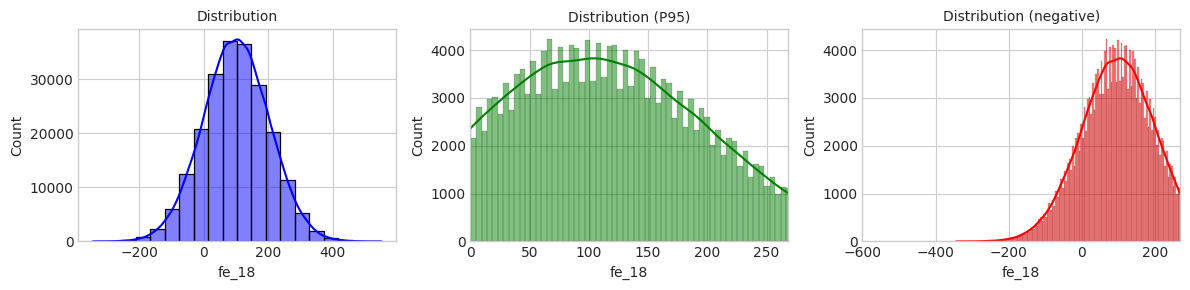


--- Column: fe_19 ---
Total Records: 215376
Missing: 0 (0.00%)
Non-Missing: 215376 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 34918 (16.21%)
+-----+
|fe_19|
+-----+
|  -73|
|  -81|
|  -37|
| -136|
|  -69|
+-----+
only showing top 5 rows


--- Statistics ---
Min: -401.00
Max: 560.00
Skewness: 0.01
Kurtosis: 0.00
5th Percentile: -63.00
25th Percentile (Q1): 31.00
75th Percentile (Q3): 167.00
95th Percentile: 262.00
Interquartile Range (IQR): 136.00
IQR Outlier Bounds: -173.00 to 371.00
Outliers: 1708 (0.79%)


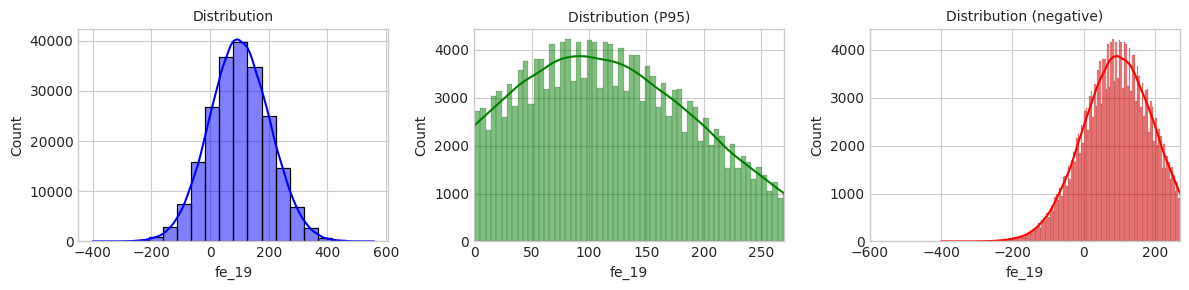


--- Column: fe_20 ---
Total Records: 215376
Missing: 0 (0.00%)
Non-Missing: 215376 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 35829 (16.64%)
+-----+
|fe_20|
+-----+
|  -28|
|  -27|
|  -83|
|  -13|
|  -49|
+-----+
only showing top 5 rows


--- Statistics ---
Min: -354.00
Max: 547.00
Skewness: -0.00
Kurtosis: -0.00
5th Percentile: -65.00
25th Percentile (Q1): 27.00
75th Percentile (Q3): 168.00
95th Percentile: 262.00
Interquartile Range (IQR): 141.00
IQR Outlier Bounds: -184.50 to 379.50
Outliers: 1414 (0.66%)


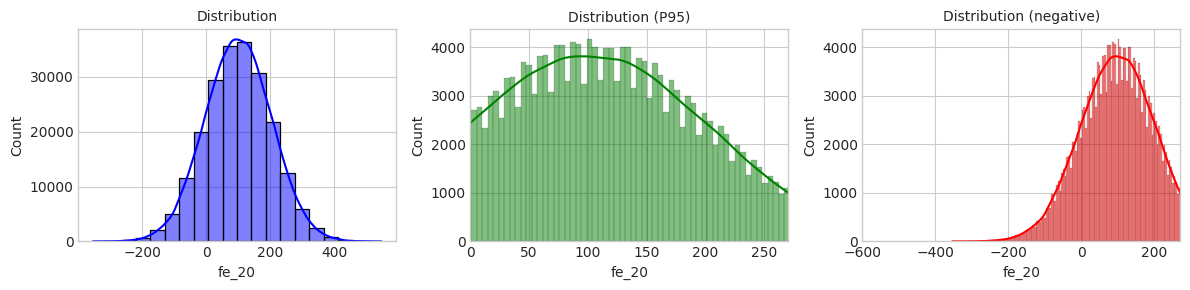

In [113]:
FILE_PATH = "data/feature_clickstream.csv"
spark = SparkSession.builder.appName("EDA").getOrCreate()
spark.sparkContext.setLogLevel("WARN")

try:
    header = spark.read.csv(FILE_PATH, header=True).columns
    df = spark.read.csv(FILE_PATH, header=True)
    print(f"--- EDA for: {FILE_PATH} ---")
    # --- String Column ---
    fields = ["Customer_ID"]
    for field in fields:
        analyze_string_column(spark, df, field)
        show_duplicates(df, field)

    # --- Numeric Column ---
    fields = [f"fe_{i}" for i in range(1, 21)]
    for field in fields:
        analyze_numeric_column(spark, df, field)

except Exception as e:
    print(f"ERROR: Could not process the file. Details: {e}")

spark.stop()

# Daily Loan 

## Daily Loan CSV Data Analysis

25/10/04 13:04:38 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/10/04 13:04:38 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


--- EDA for: data/lms_loan_daily.csv ---

--- Column: loan_id ---
Total Records: 137500
Missing: 0 (0.00%)
Non-Missing: 137500 (100.00%)
Distinct Values: 12500 (9.09%)
Duplicates: 137500 (100.00%)
Total duplicate rows beyond first occurrence: 125000 (90.91%)
Distinct Duplicates: 12500 (9.09%)

--- Column: Customer_ID ---
Total Records: 137500
Missing: 0 (0.00%)
Non-Missing: 137500 (100.00%)
Distinct Values: 12500 (9.09%)
Duplicates: 137500 (100.00%)
Total duplicate rows beyond first occurrence: 125000 (90.91%)
Distinct Duplicates: 12500 (9.09%)

--- Column: tenure ---
Total Records: 137500
Missing: 0 (0.00%)
Non-Missing: 137500 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 10.00
Max: 10.00
Skewness: NA
Kurtosis: NA
5th Percentile: 10.00
25th Percentile (Q1): 10.00
75th Percentile (Q3): 10.00
95th Percentile: 10.00
Interquartile Range (IQR): 0.00
IQR Outlier Bounds: 10.00 to 10.00
Outliers: 0 (0.00%)


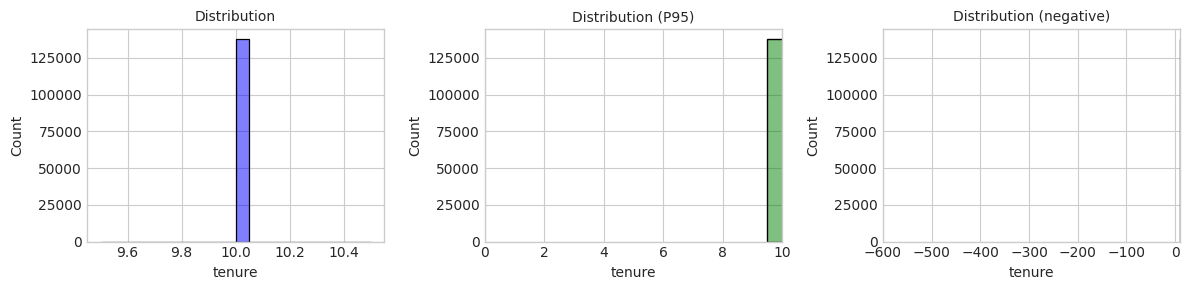


--- Column: installment_num ---
Total Records: 137500
Missing: 0 (0.00%)
Non-Missing: 137500 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 0.00
Max: 10.00
Skewness: -0.00
Kurtosis: -1.22
5th Percentile: 0.00
25th Percentile (Q1): 2.00
75th Percentile (Q3): 8.00
95th Percentile: 10.00
Interquartile Range (IQR): 6.00
IQR Outlier Bounds: -7.00 to 17.00
Outliers: 0 (0.00%)


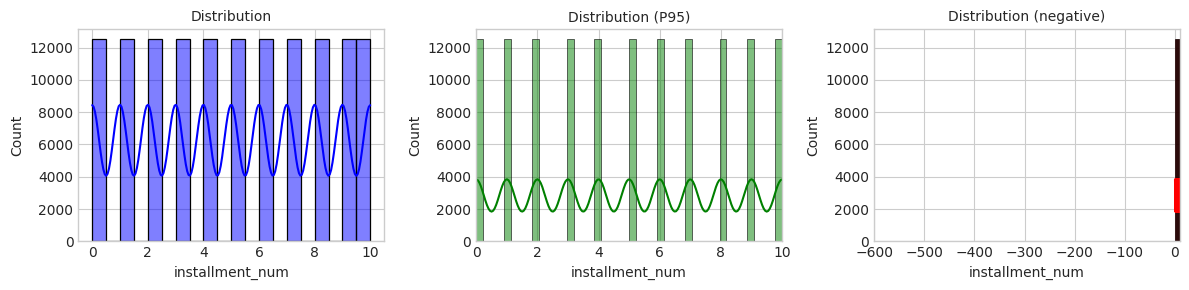


--- Column: loan_amt ---
Total Records: 137500
Missing: 0 (0.00%)
Non-Missing: 137500 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 10000.00
Max: 10000.00
Skewness: NA
Kurtosis: NA
5th Percentile: 10000.00
25th Percentile (Q1): 10000.00
75th Percentile (Q3): 10000.00
95th Percentile: 10000.00
Interquartile Range (IQR): 0.00
IQR Outlier Bounds: 10000.00 to 10000.00
Outliers: 0 (0.00%)


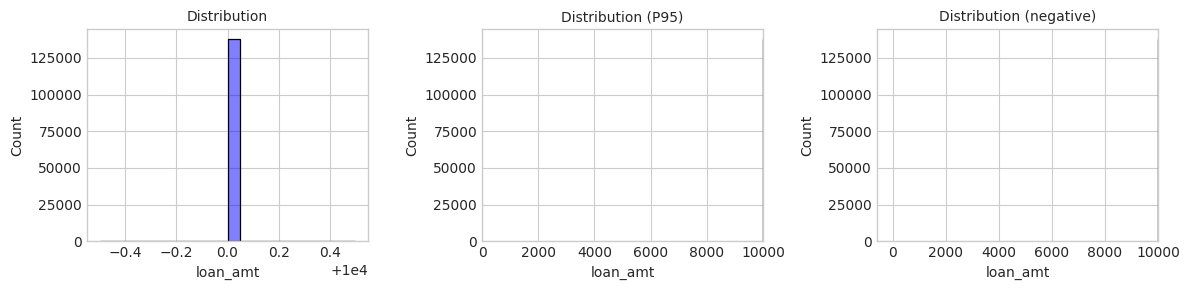


--- Column: due_amt ---
Total Records: 137500
Missing: 0 (0.00%)
Non-Missing: 137500 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 0.00
Max: 1000.00
Skewness: -2.85
Kurtosis: 6.10
5th Percentile: 0.00
25th Percentile (Q1): 1000.00
75th Percentile (Q3): 1000.00
95th Percentile: 1000.00
Interquartile Range (IQR): 0.00
IQR Outlier Bounds: 1000.00 to 1000.00
Outliers: 12500 (9.09%)


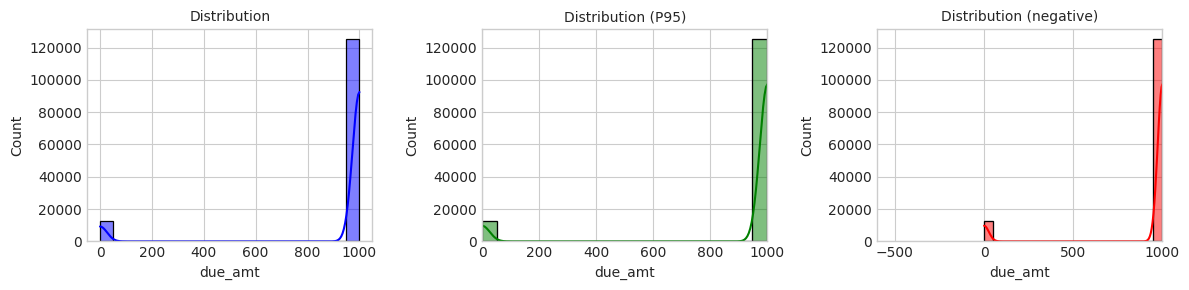


--- Column: paid_amt ---
Total Records: 137500
Missing: 0 (0.00%)
Non-Missing: 137500 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 0.00
Max: 4000.00
Skewness: -0.37
Kurtosis: 0.41
5th Percentile: 0.00
25th Percentile (Q1): 0.00
75th Percentile (Q3): 1000.00
95th Percentile: 1000.00
Interquartile Range (IQR): 1000.00
IQR Outlier Bounds: -1500.00 to 2500.00
Outliers: 277 (0.20%)


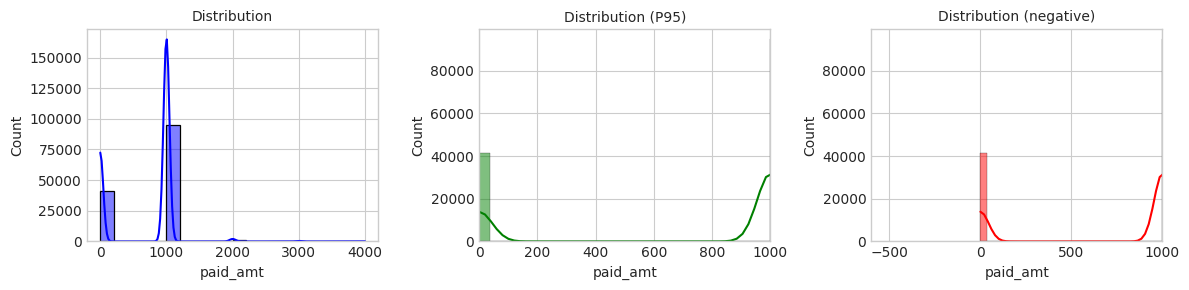


--- Column: overdue_amt ---
Total Records: 137500
Missing: 0 (0.00%)
Non-Missing: 137500 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 0.00
Max: 10000.00
Skewness: 2.35
Kurtosis: 4.51
5th Percentile: 0.00
25th Percentile (Q1): 0.00
75th Percentile (Q3): 0.00
95th Percentile: 6000.00
Interquartile Range (IQR): 0.00
IQR Outlier Bounds: 0.00 to 0.00
Outliers: 28876 (21.00%)


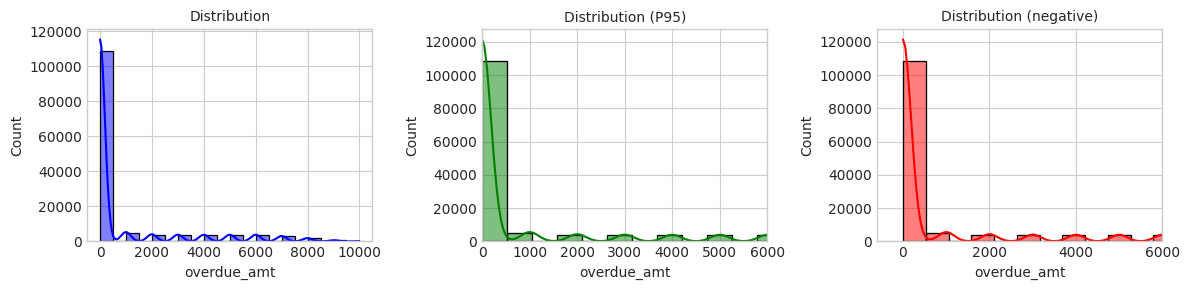


--- Column: balance ---
Total Records: 137500
Missing: 0 (0.00%)
Non-Missing: 137500 (100.00%)
Non-numeric Values: 0 (0.00%)
Negative Values: 0 (0.00%)

--- Statistics ---
Min: 0.00
Max: 10000.00
Skewness: -0.46
Kurtosis: -0.98
5th Percentile: 0.00
25th Percentile (Q1): 3000.00
75th Percentile (Q3): 8000.00
95th Percentile: 10000.00
Interquartile Range (IQR): 5000.00
IQR Outlier Bounds: -4500.00 to 15500.00
Outliers: 0 (0.00%)


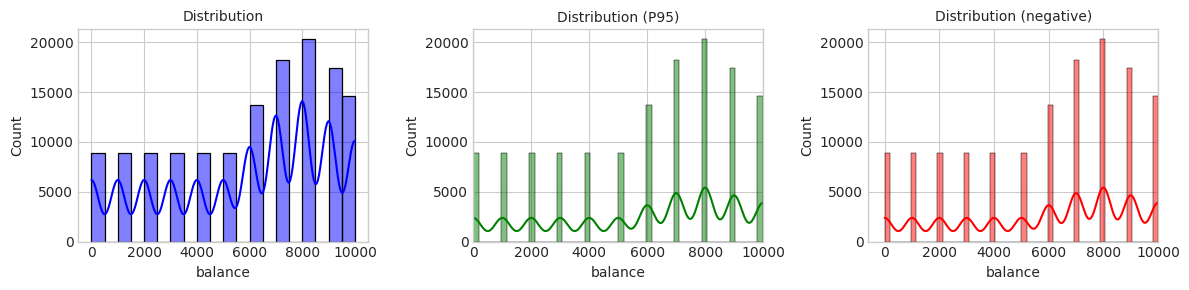


--- Column: fe_1 ---
ERROR: Could not process the file. Details: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `fe_1` cannot be resolved. Did you mean one of the following? [`due_amt`, `tenure`, `loan_id`, `balance`, `loan_amt`].;
'Filter isnull('fe_1)
+- Relation [loan_id#77061,Customer_ID#77062,loan_start_date#77063,tenure#77064,installment_num#77065,loan_amt#77066,due_amt#77067,paid_amt#77068,overdue_amt#77069,balance#77070,snapshot_date#77071] csv



In [114]:
FILE_PATH = "data/lms_loan_daily.csv"
spark = SparkSession.builder.appName("EDA").getOrCreate()
spark.sparkContext.setLogLevel("WARN")

try:
    header = spark.read.csv(FILE_PATH, header=True).columns
    df = spark.read.csv(FILE_PATH, header=True)
    print(f"--- EDA for: {FILE_PATH} ---")
    # --- String Column ---
    fields = ["loan_id","Customer_ID"]
    for field in fields:
        analyze_string_column(spark, df, field)
        # show_duplicates(df, field)

    # --- Numeric Column ---
    fields = ["tenure","installment_num","loan_amt","due_amt","paid_amt","overdue_amt","balance"]
    for field in fields:
        analyze_numeric_column(spark, df, field)
    
    fields = [f"fe_{i}" for i in range(1, 21)]
    for field in fields:
        analyze_numeric_column(spark, df, field)

except Exception as e:
    print(f"ERROR: Could not process the file. Details: {e}")

spark.stop()